# Exploratory Data Analysis

## Data Cleanup
Removing duplicates and uncomplete samples, merging examples with the same URL.

In [1]:
import pandas as pd
import numpy as np
import music21 as m21
import json

from src import chord_parser

In [2]:
parser = chord_parser.Main()

In [3]:
data = pd.read_csv("../Data/data_raw.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32792 entries, 0 to 32791
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        32792 non-null  object 
 1   title      32792 non-null  object 
 2   artist     32792 non-null  object 
 3   decade     32792 non-null  int64  
 4   genre      32792 non-null  object 
 5   ratings    27892 non-null  float64
 6   stars      27892 non-null  float64
 7   chords     32792 non-null  object 
 8   chord_map  32792 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.3+ MB


In [4]:
# Clean up nan values and duplicates
data.drop_duplicates(inplace=True)
data.dropna(subset=["chords"], inplace=True)
data.fillna(0, inplace=True)

# Clean up low quality data
# data.drop(data[data["stars"] < 4.5].index, inplace=True)
# data.drop(data[data["ratings"] < 10].index, inplace=True)

In [5]:
# Merge rows with same url
agg_funcs = {
    "title": "first",
    "artist": "first",
    "decade": "first",
    "genre": "|".join,
    "ratings": "first",
    "stars": "first",
    "chords": "first",
    "chord_map": "first",
}

data = data.groupby("url", as_index=False).aggregate(agg_funcs)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29958 entries, 0 to 29957
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        29958 non-null  object 
 1   title      29958 non-null  object 
 2   artist     29958 non-null  object 
 3   decade     29958 non-null  int64  
 4   genre      29958 non-null  object 
 5   ratings    29958 non-null  float64
 6   stars      29958 non-null  float64
 7   chords     29958 non-null  object 
 8   chord_map  29958 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.1+ MB


In [6]:
# Merge rows with the same title and artist, choose the one with the higher ratings
data = data.sort_values(by="ratings", ascending=False)
data = data.drop_duplicates(subset=["title", "artist"], keep="first")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24300 entries, 14477 to 13097
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        24300 non-null  object 
 1   title      24300 non-null  object 
 2   artist     24300 non-null  object 
 3   decade     24300 non-null  int64  
 4   genre      24300 non-null  object 
 5   ratings    24300 non-null  float64
 6   stars      24300 non-null  float64
 7   chords     24300 non-null  object 
 8   chord_map  24300 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.9+ MB


## Chord cleanup
Not all chord symbols scraped can be easily recognized, therefore it is needed to clean unusual chords. We can use the chord map dictionary obtained during scraping to help us use more chords.

In [7]:
all_chords = set()
for index, row in data.iterrows():
    # Chords contain a space-separated sequence of chords
    chords = row["chords"].split(" ")
    # We want to add all the unique chords in that sequence to our set
    all_chords.update(chords)
all_chords = sorted(all_chords)
len(all_chords)

3168

To make sure that our assumption about one chord symbol to one note representation is correct, we can iterate over the dataset and look for any inconsistencies.

In [8]:
# Parse the saved representation of the chord map
data["chord_map"] = data["chord_map"].apply(lambda x: json.loads(x.replace("'", '"')))

temp_map = {}
for chord_map in data["chord_map"].values:
    for chord, rep in chord_map.items():
        if chord in temp_map.values() and temp_map[chord] != rep:
            print(f"Found a mismatch for {chord}: {rep} and {temp_map[chord]}!")
        temp_map[chord] = rep

Since we have not found any mismatches, we will build a complete chord map to help us parse the chords later.

In [9]:
# Create a dictionary of all chords and their corresponding notes
mods = ["--", "-", "", "#", "##"]
note_names = ["C", "D", "E", "F", "G", "A", "B"]
all_notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
note_map = {}
for note in note_names:
    for mod in mods:
        p = m21.pitch.Pitch(note + mod)
        enharmonics = p.getAllCommonEnharmonics()
        enharmonics.append(p)
        for enh in enharmonics:
            enh = str(enh)
            if enh in all_notes:
                note_map[note + mod] = enh

# Does not also add C-- and F--
note_map["C--"] = "A#"
note_map["F--"] = "D#"

In [10]:
# Instead of just using the map as it is, we will transpose it to all possible keys
complete_chord_map = {}
for key, value in temp_map.items():
    root, ext = parser.get_root_and_ext(key)
    root = note_map[root.replace("H", "B")]
    ext = parser.update_if_slash(root, ext)

    for mod_note, note in note_map.items():
        new_ext = parser.inverse_update_if_slash(mod_note, ext)
        
        # Transpose the chord to the new key
        chord_notes = (np.array(value) + all_notes.index(note) - all_notes.index(root)).tolist()
        
        complete_chord_map[mod_note.replace("-", "b") + new_ext] = chord_notes

# Do not use any chords that are not in the all_chords set
new_chord_map = complete_chord_map.copy()
for chord in complete_chord_map.keys():
    if chord not in all_chords:
        del new_chord_map[chord]
complete_chord_map = new_chord_map.copy()
len(complete_chord_map)

2336

In [11]:
# Save complete chord map to a file
with open("../Data/chord_map.json", "w") as f:
    f.write(json.dumps(complete_chord_map))

In [12]:
# Get the rows with unrecognized chords
problematic_indices = []
for index, row in data.iterrows():
    chords = row["chords"].split(" ")
    for chord in chords:
        if chord not in complete_chord_map and chord != "":
            problematic_indices.append(index)
            break
print(f"There are a total of {len(problematic_indices)} problematic rows")

There are a total of 1933 problematic rows


Let's check some statistics of the problematic data and compare it to the complete data.

In [13]:
print(
    data["ratings"].median(),
    data["ratings"].mean(),
    data["stars"].median(),
    data["stars"].mean(),
)

24.0 269.4283950617284 5.0 4.0182304526748975


In [14]:
problematic_data = data.loc[problematic_indices, :]
print(
    problematic_data["ratings"].median(),
    problematic_data["ratings"].mean(),
    problematic_data["stars"].median(),
    problematic_data["stars"].mean(),
)

15.0 139.5028453181583 4.5 3.865494050698396


It seems that the problematic data is of a lower quality given the number of ratings and stars, so we can drop this data without possibly sacrificing a meaningful portion of the dataset. Also, the `chord_map` column will not be useful anymore, as we have already obtained a complete chord map for parsing the chord symbols.

In [15]:
# Drop the problematic rows and the chord_map column
data.drop(problematic_indices, inplace=True)
data.drop(["chord_map"], axis=1, inplace=True)

# Fix the index
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22367 entries, 0 to 22366
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   url      22367 non-null  object 
 1   title    22367 non-null  object 
 2   artist   22367 non-null  object 
 3   decade   22367 non-null  int64  
 4   genre    22367 non-null  object 
 5   ratings  22367 non-null  float64
 6   stars    22367 non-null  float64
 7   chords   22367 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.4+ MB


Since we only care about the harmonic changes, let's also clean the consecutive chords in a sequence.

In [16]:
# Merge the repeated chords
for index, row in data.iterrows():
    chords = row["chords"].split(" ")
    # Check if two chords after each other are the same
    # Merge such chords so that only the harmonic changes are recorded
    merged_chords = []
    for i in range(len(chords)):
        if i == 0:
            merged_chords.append(chords[i])
        elif chords[i] != chords[i - 1]:
            merged_chords.append(chords[i])
            
    # Replace the chords with the merged chords
    data.at[index, "chords"] = " ".join(merged_chords).strip()

In [17]:
data.to_csv("../Data/data_cleaned.csv", index=False)

## Exploratory data analysis

### General info

#### Imports and preprocessing

In [18]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [19]:
### Preprocessing for EDA ###
# Obtain the number of chords, unique chords, and unique roots for each song
num_chords = []
num_unique_chords = []
num_unique_roots = []
for index, row in data.iterrows():
    chords = row["chords"].split(" ")
    num_chords.append(len(chords))
    num_unique_chords.append(len(set(chords)))
    song_unique_roots = []
    for chord in chords:
        root, ext = "", ""
        if len(chord) > 1 and (chord[1] == "#" or chord[1] == "b"):
            root, ext = chord[:2], chord[2:]
        else:
            root, ext = chord[0], chord[1:]
        song_unique_roots.append(root)
    num_unique_roots.append(len(set(song_unique_roots)))
    
# Add the new columns to the dataframe
data_for_eda = data.copy()
data_for_eda["num_chords"] = num_chords
data_for_eda["num_unique_chords"] = num_unique_chords
data_for_eda["num_unique_roots"] = num_unique_roots

# Split rows with multiple genres into multiple rows
# Used for genre-specific EDA
data_split = data_for_eda.copy()
data_split = (
    data_for_eda.assign(genre=data["genre"].str.split("|"))
    .explode("genre")
    .reset_index(drop=True)
)

#### Root and extension distribution

In [20]:
### Get the frequencies of roots and extensions ###
slash_map = {}
notes = ["C", "C#", "C-", "D", "D#", "D-", "E", "E-", "F", "F#", "F-", "G", "G#", "G-", "A", "A#", "A-", "B", "B-"]
for root in notes:
    for bass in notes:
        if root != bass:
            figure = m21.roman.romanNumeralFromChord(m21.chord.Chord(root), bass).figure
            # Upper the figure except for the b or # in the beggining (if there is one)
            if len(figure) > 1 and (figure[0] == "b" or figure[0] == "#"):
                figure = figure[0] + figure[1:].upper()
            else:
                figure = figure.upper()
            slash_map[f"{root}/{bass}"] = figure

def update_if_slash(root, extension):
    """Get the relative extension if it is a slash chord."""
    if "/" in extension:
        bass = extension.split("/")[1].replace("b", "-")
        slash_pair = root.replace("b", "-") + "/" + bass
        if slash_pair in slash_map:
            extension = extension.split("/")[0] + "/" + slash_map[slash_pair]
    return extension

def update_frequency(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1
    return dictionary

# General frequencies
root_frequncies = {}
extension_frequncies = {}
for index, row in data_for_eda.iterrows():
    row_chords = row["chords"].split(" ")[:-1]
    for chord in row_chords:
        root, ext = "", ""
        if len(chord) > 1 and (chord[1] == "#" or chord[1] == "b"):
            root, ext = chord[:2], chord[2:]
        else:
            root, ext = chord[0], chord[1:]

        ext = update_if_slash(root, ext)
        root_frequncies = update_frequency(root_frequncies, root)
        extension_frequncies = update_frequency(extension_frequncies, ext)        

In [21]:
# Genre specific frequencies
genre_root_frequncies = {}
genre_extension_frequncies = {}

for index, row in data_split.iterrows():
    genre = row["genre"]
    row_chords = row["chords"].split(" ")[:-1]

    for chord in row_chords:
        root, ext = "", ""
        if len(chord) > 1 and (chord[1] == "#" or chord[1] == "b"):
            root, ext = chord[:2], chord[2:]
        else:
            root, ext = chord[0], chord[1:]
            
        ext = update_if_slash(root, ext)


        # Update the genre-specific root frequencies
        if genre not in genre_root_frequncies:
            genre_root_frequncies[genre] = {}
        genre_root_frequncies[genre] = update_frequency(genre_root_frequncies[genre], root)

        # Update the genre-specific extension frequencies
        if genre not in genre_extension_frequncies:
            genre_extension_frequncies[genre] = {}
        genre_extension_frequncies[genre] = update_frequency(genre_extension_frequncies[genre], ext)

In [22]:
# Show the most common roots
root_frequency_sum = np.array([x[1] for x in root_frequncies.items()], dtype=np.int32).sum()
sorted_root_frequncies = sorted(
    root_frequncies.items(), key=lambda x: x[1], reverse=True
)
relative_root_frequncies = {
    key: value / root_frequency_sum for key, value in sorted_root_frequncies
}
relative_root_frequncies_df = pd.DataFrame(
    relative_root_frequncies.items(), columns=["root", "frequency"]
)
relative_root_frequncies_df["frequency"] = relative_root_frequncies_df[
    "frequency"
].apply(lambda x: round(x, 4))
relative_root_frequncies_df[:10]

,root,frequency
0,G,0.1614
1,A,0.1519
2,D,0.1509
3,C,0.1390
4,E,0.1189
5,F,0.0794
6,B,0.0610
7,F#,0.0317
8,Bb,0.0256
9,C#,0.0199


In [23]:
# Show the most common extensions
extension_frequncy_sum = np.array([x[1] for x in extension_frequncies.items()], dtype=np.int32).sum()
sorted_extension_frequncies = sorted(
    extension_frequncies.items(), key=lambda x: x[1], reverse=True
)
percentual_extension_frequncies = {
    key: value / extension_frequncy_sum for key, value in sorted_extension_frequncies
}
percentual_extension_frequncies_df = pd.DataFrame(
    percentual_extension_frequncies.items(), columns=["extension", "frequency"]
)
percentual_extension_frequncies_df["frequency"] = percentual_extension_frequncies_df[
    "frequency"
].apply(lambda x: round(x, 4))
percentual_extension_frequncies_df[:10]

,extension,frequency
0,,0.5869
1,m,0.2254
2,7,0.0638
3,m7,0.0335
4,maj7,0.0156
5,/bVI,0.0110
6,5,0.0086
7,sus4,0.0055
8,add9,0.0050
9,/IV,0.0044


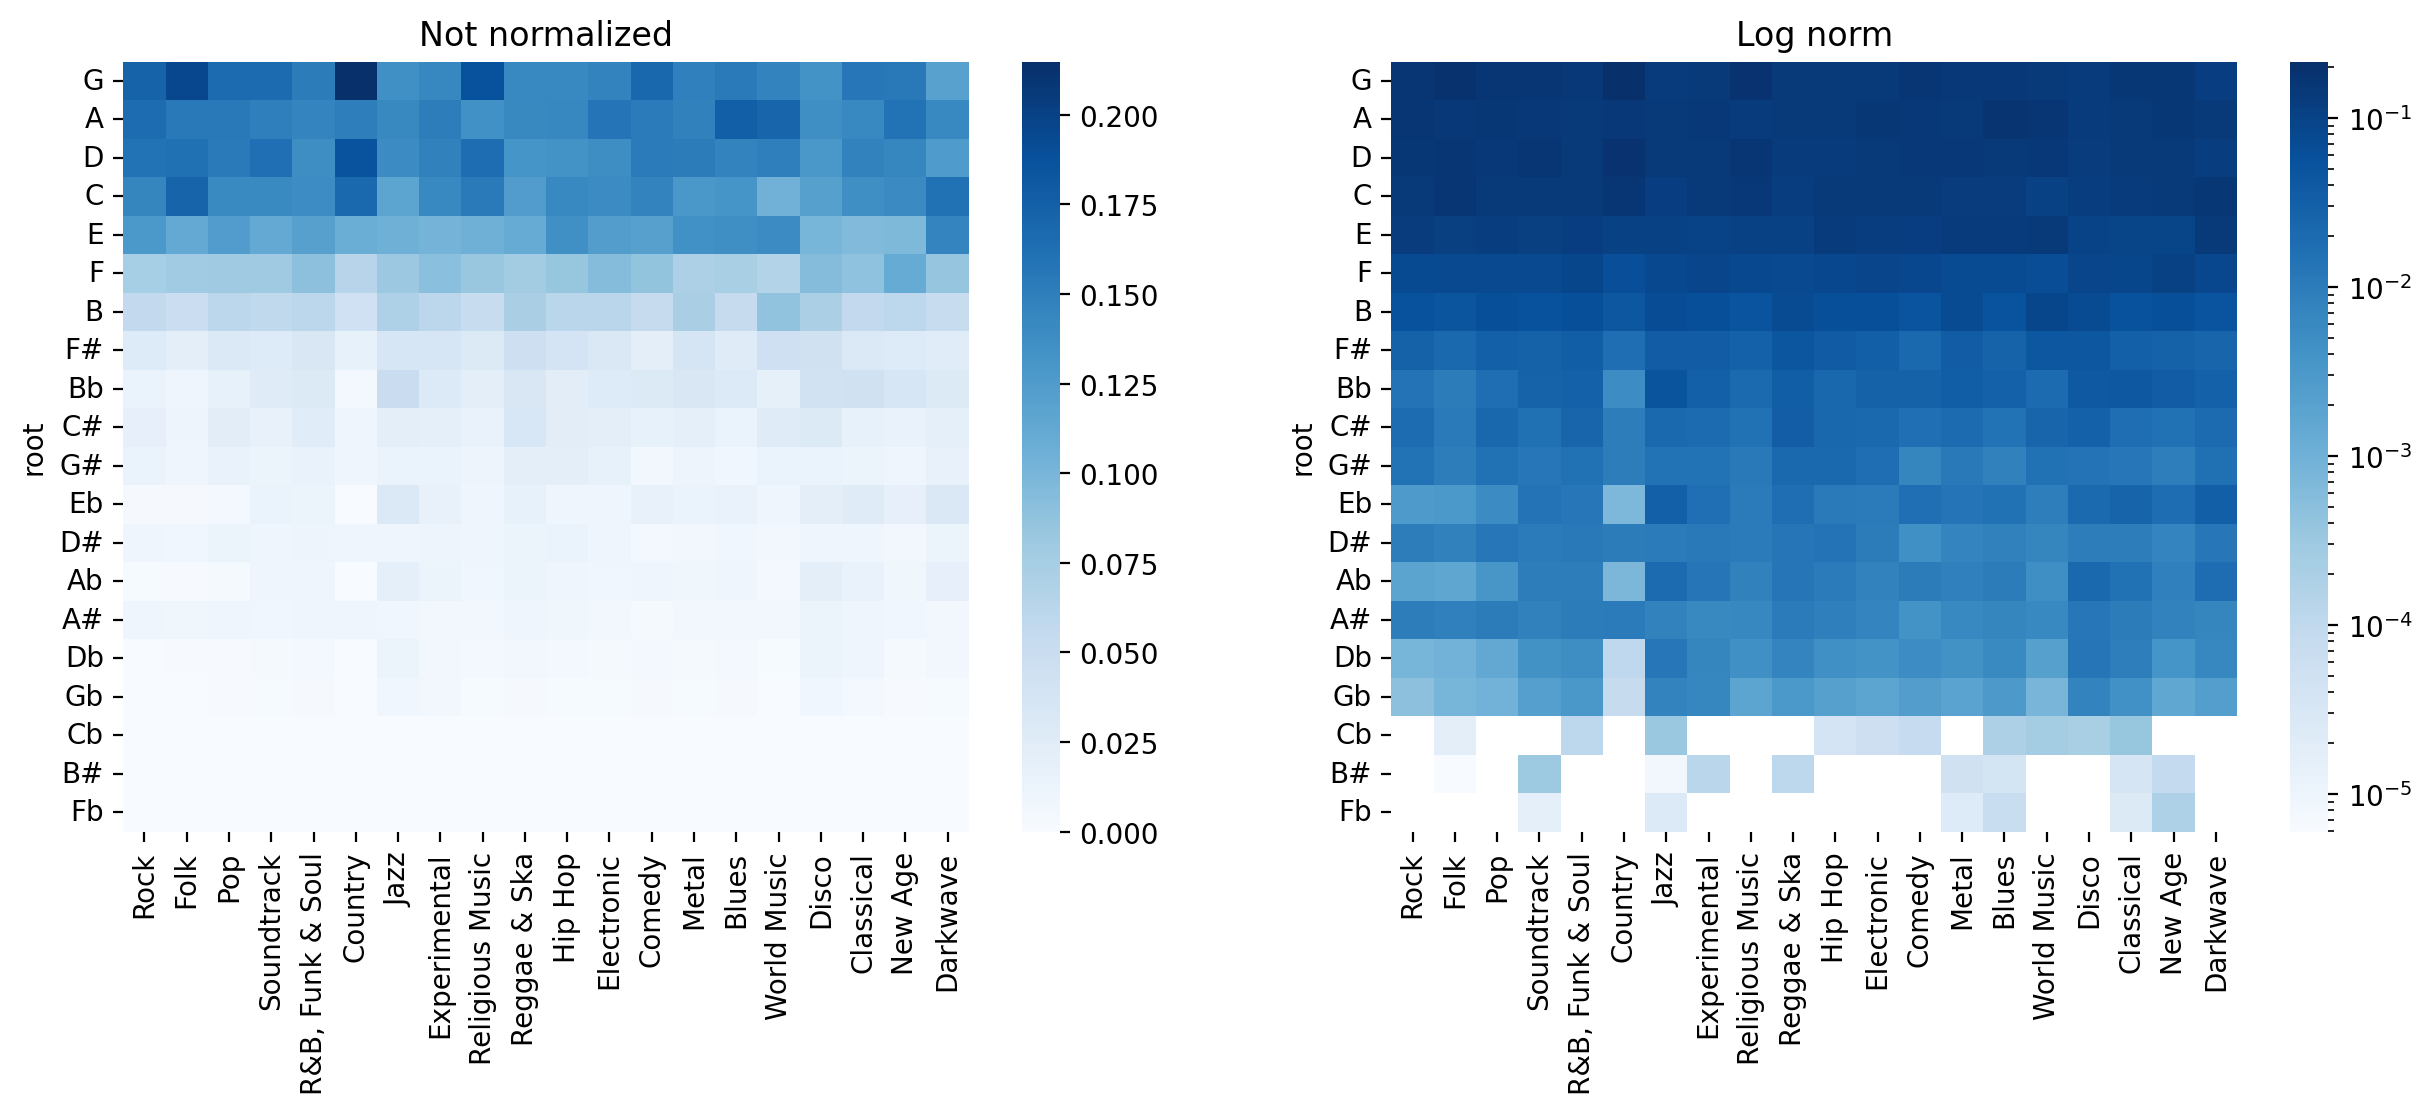

In [24]:
### Show the most common roots for each genre ###
genre_root_frequncies_df = pd.DataFrame(genre_root_frequncies)
genre_root_frequncies_df = genre_root_frequncies_df.fillna(0)

# Convert to relative frequency
genre_root_frequncies_df = genre_root_frequncies_df.div(
    genre_root_frequncies_df.sum(axis=0), axis=1
)

# Sort the rows based on the most common roots
genre_root_frequncies_df = genre_root_frequncies_df.reindex(
    relative_root_frequncies_df["root"]
)

# Plot the heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Not normalized")
sns.heatmap(genre_root_frequncies_df, cmap="Blues", annot=False, fmt="g", ax=ax1)
ax2.set_title("Log norm")
sns.heatmap(genre_root_frequncies_df, cmap="Blues", norm=LogNorm(), annot=False, fmt="g", ax=ax2)
plt.show()

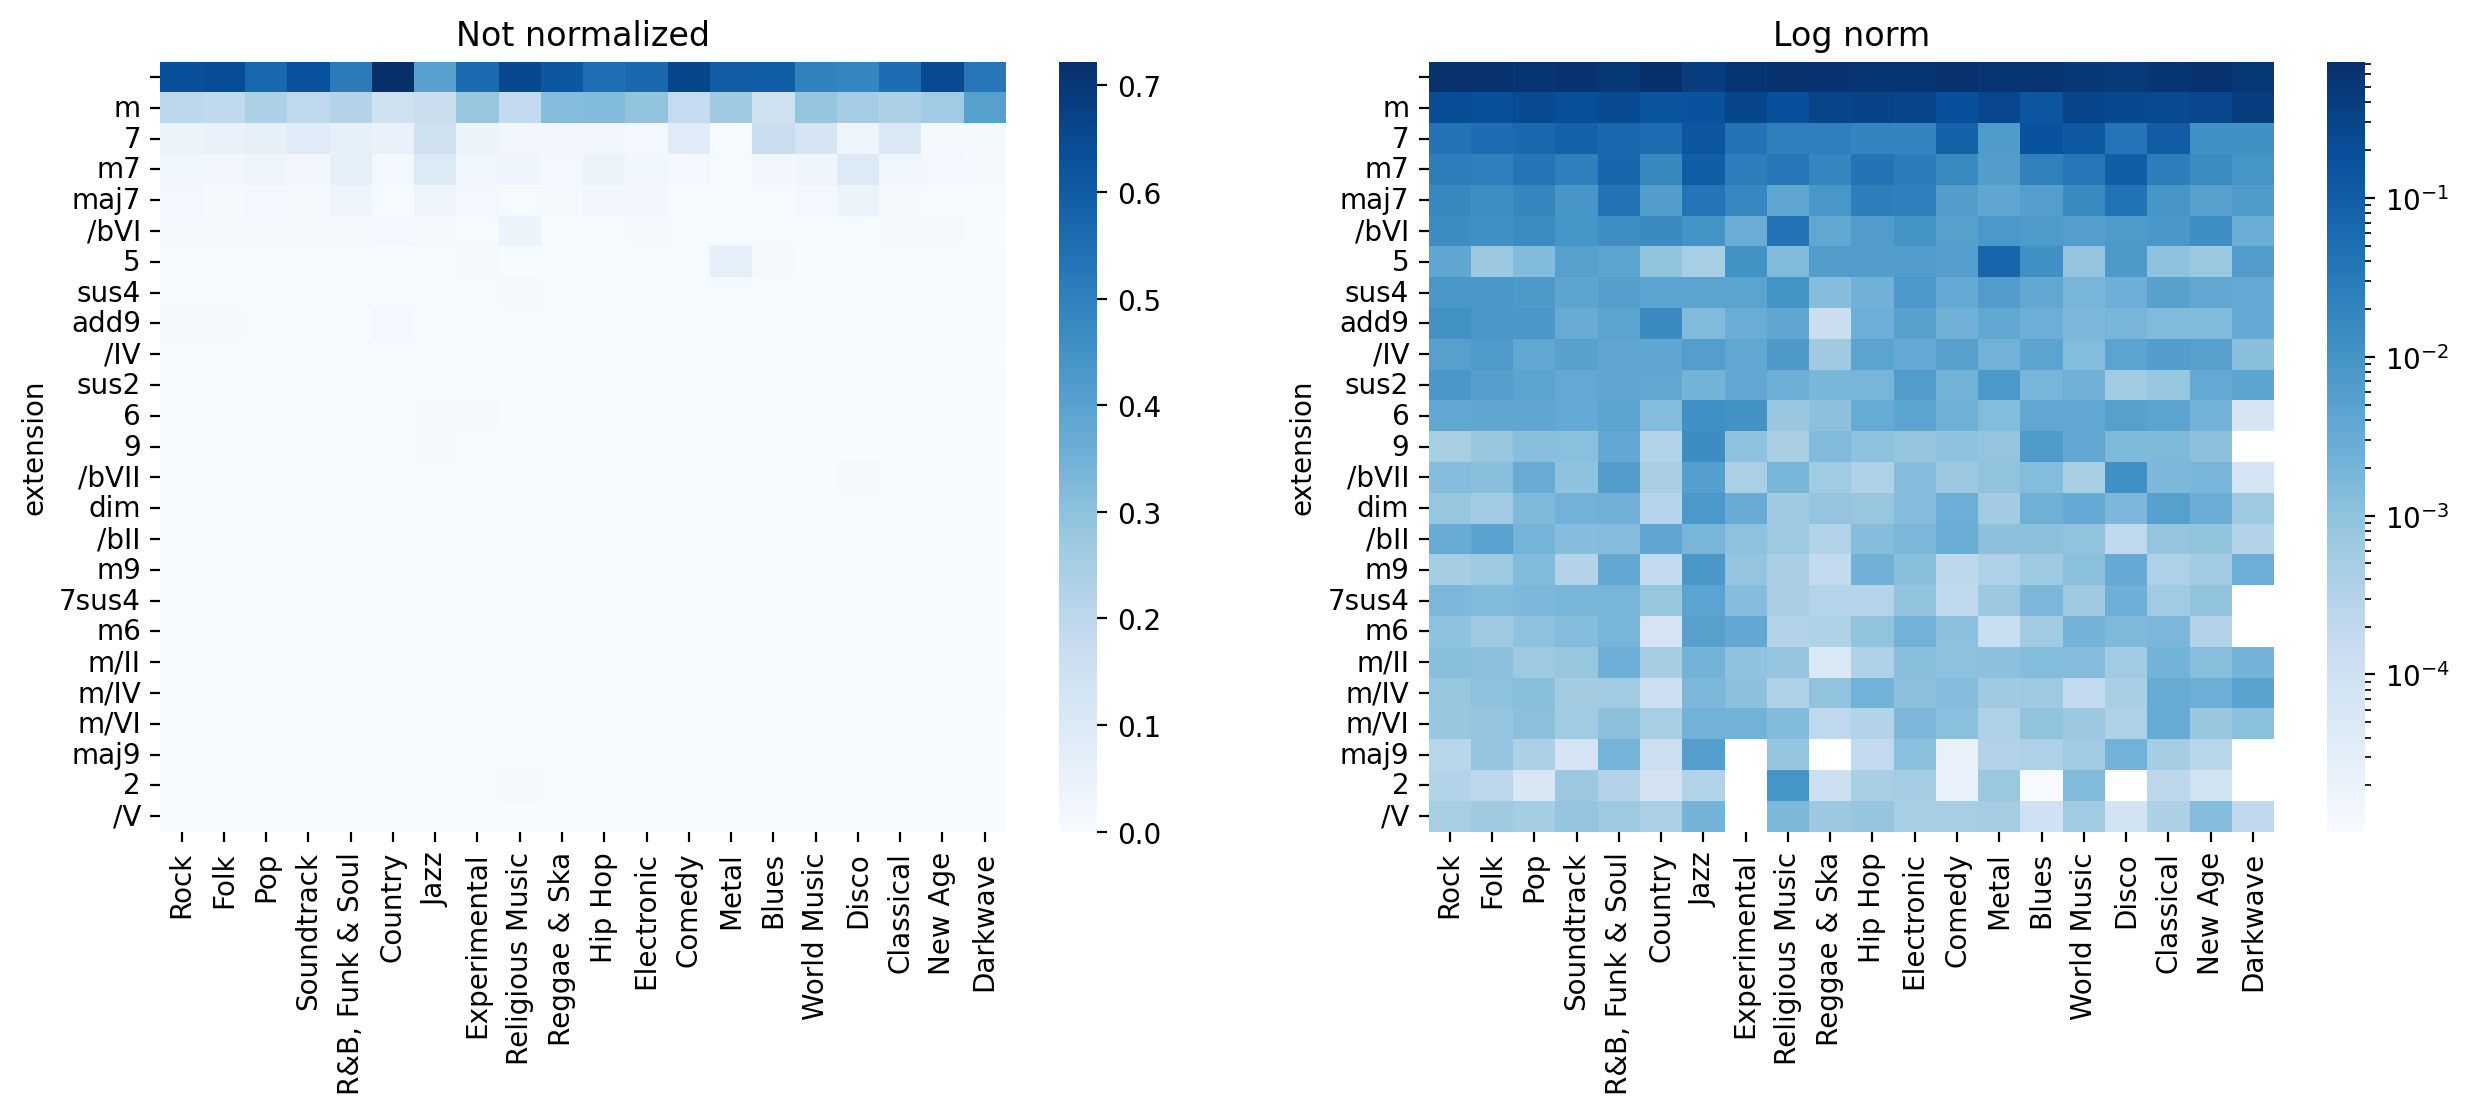

In [25]:
### Show the most common extensions for each genre ###
genre_extension_frequncies_df = pd.DataFrame(genre_extension_frequncies)
genre_extension_frequncies_df = genre_extension_frequncies_df.fillna(0)

# Convert to relative frequency
genre_extension_frequncies_df = genre_extension_frequncies_df.div(
    genre_extension_frequncies_df.sum(axis=0), axis=1
)

# Sort the rows based on the most common roots
genre_extension_frequncies_df = genre_extension_frequncies_df.reindex(
    percentual_extension_frequncies_df["extension"]
)

# Plot the heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Not normalized")
sns.heatmap(genre_extension_frequncies_df[:25], cmap="Blues", annot=False, fmt="g", ax=ax1)
ax2.set_title("Log norm")
sns.heatmap(genre_extension_frequncies_df[:25], cmap="Blues", norm=LogNorm(), annot=False, fmt="g", ax=ax2)
plt.show()

#### Artists

In [26]:
# Show the most most common artists as well as their number of songs and the genres
top_10_artist_counts = data_split["artist"].value_counts().head(10)

top_10_artists = pd.DataFrame()
top_10_artists["artist"] = top_10_artist_counts.index  # Artist names
top_10_artists["songs"] = top_10_artist_counts.values  # Number of songs
top_10_artists["genre"] = top_10_artists["artist"].map(data_split.groupby("artist")["genre"].unique().apply(list))

top_10_artists

,artist,songs,genre
0,Elvis Presley,223,"[Soundtrack, R&B, Funk & Soul, Rock, Pop, Reli..."
1,Taylor Swift,149,"[Rock, Country, Folk, Pop]"
2,Bob Marley,141,"[Reggae & Ska, Hip Hop]"
3,Johnny Cash,135,"[Country, Rock, Folk, Religious Music, Soundtr..."
4,Bob Dylan,110,"[Country, Folk, Rock, Blues, Soundtrack, Jazz]"
5,"""Weird Al"" Yankovic",103,"[Comedy, Rock]"
6,Zach Bryan,100,"[Folk, Country]"
7,The Beatles,87,"[Rock, Experimental, Soundtrack]"
8,Frank Sinatra,85,"[Jazz, Pop]"
9,Eric Clapton,82,"[Rock, Blues, Pop]"


In [27]:
# The most occuring artists by genre
df_counts = data_split.groupby("genre")["artist"].value_counts().reset_index(name="counts")
df_counts['rank'] = df_counts.groupby('genre')['counts'].rank(method='first', ascending=False).astype(int)

# Show the number of their songs in the artist's name
df_counts["artist"] = df_counts["artist"] + " (" + df_counts["counts"].astype(str) + ")"
df_counts[df_counts["rank"] <= 5].pivot(index="rank", columns="genre", values="artist")

genre,Blues,Classical,Comedy,Country,Darkwave,Disco,Electronic,Experimental,Folk,Hip Hop,Jazz,Metal,New Age,Pop,"R&B, Funk & Soul",Reggae & Ska,Religious Music,Rock,Soundtrack,World Music
rank,,,,,,,,,,,,,,,,,,,,
1,Eric Clapton (73),Rainald Grebe (60),"""Weird Al"" Yankovic (102)",Johnny Cash (94),Chelsea Wolfe (32),Camilo Sesto (41),Depeche Mode (53),Avey Tare (17),Bob Dylan (69),twenty one pilots (39),Frank Sinatra (66),Iron Maiden (43),Enya (75),Elvis Presley (49),Adele (32),Bob Marley (137),Hillsong Worship (75),The Beatles (82),Will Tura (68),Javier Solís (58)
2,Muddy Waters (61),The Tiger Lillies (53),Stephen Lynch (46),Zach Bryan (58),Cocteau Twins (25),Calvin Harris (28),Pet Shop Boys (25),Kaláka (16),Taylor Swift (56),Eminem (27),Norah Jones (51),Scorpions (30),Celtic Woman (34),Taylor Swift (36),Prince (31),Peter Tosh (58),Chris Tomlin (44),Elvis Presley (69),Glee Cast (62),Los Panchos (Trio Los Panchos) (49)
3,B.B. King (56),Steam Powered Giraffe (44),Bo Burnham (43),Hank Williams (45),Deine Lakaien (17),Boney M. (23),The Weeknd (24),Otto Waalkes (14),Zach Bryan (42),Kanye West (24),Nat King Cole (30),Metallica (29),Clannad (28),Billie Eilish (34),Fats Domino (30),UB40 (54),Hillsong United (42),Buddy Holly (26),Rolf Zuckowski (49),José Alfredo Jiménez (48)
4,Gary Moore (46),Toon Hermans (40),Tim Minchin (37),Willie Nelson (44),Emilie Autumn (11),Modern Talking (20),Erasure (18),Cosmo Sheldrake (12),Ed Sheeran (33),NF (22),Ella Fitzgerald (26),Avenged Sevenfold (27),Loreena McKennitt (28),Georges Brassens (33),Stevie Wonder (30),Madness (44),Elvis Presley (40),Coldplay (22),Elvis Presley (46),Pedro Infante (44)
5,Keb' Mo' (46),Taizé (37),Björn Rosenström (34),Taylor Swift (37),Dead Can Dance (10),Benjamin Ingrosso (17),Moby (18),Yoko Ono (10),John Prine (30),Alligatoah (18),Jamie Cullum (26),Sabaton (25),Secret Garden (15),Ed Sheeran (30),Michael Jackson (25),Stick Figure (36),Elevation Worship (36),Harry Styles (22),Gene Autry (28),Juan Gabriel (40)


#### Data distribution

In [28]:
def color_by_height(values, palette):
    cmap = sns.color_palette(palette, as_cmap=True)
    norm = plt.Normalize(values.min(), values.max())
    return cmap(norm(values))

<AxesSubplot:>

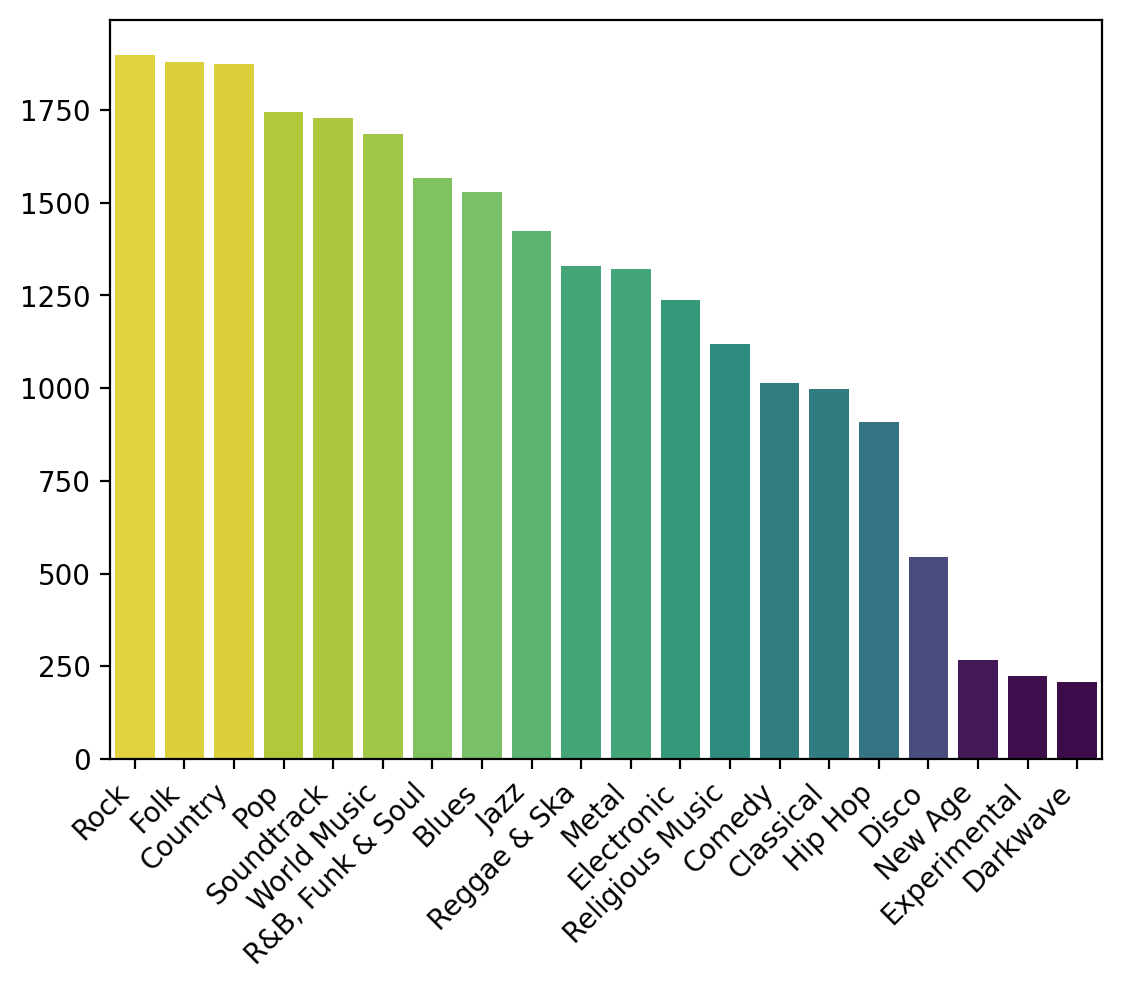

In [29]:
# Check the istribution of genres in the dataset, where each song can have multiple genres
genres = data["genre"].str.split("|").explode().value_counts()

plt.xticks(rotation=45, horizontalalignment="right")
sns.barplot(x=genres.index, y=genres.values, palette=color_by_height(genres.values, "viridis"))

<AxesSubplot:>

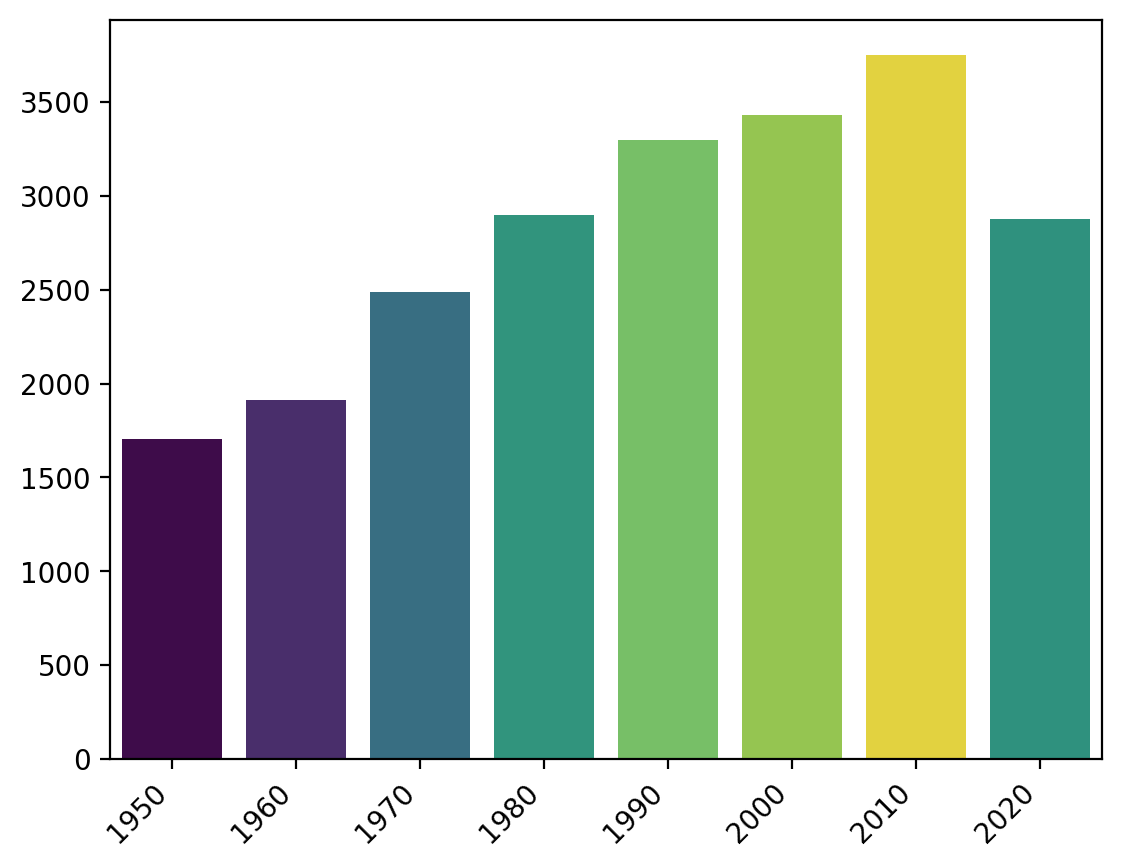

In [30]:
# Check the distribution of the decades
decades = data["decade"].value_counts().sort_index()
plt.xticks(rotation=45, horizontalalignment="right")
sns.barplot(x=decades.index, y=decades.values, palette=color_by_height(decades.values, "viridis"))

### Complexity

#### Uniqueness

80.5747943490701

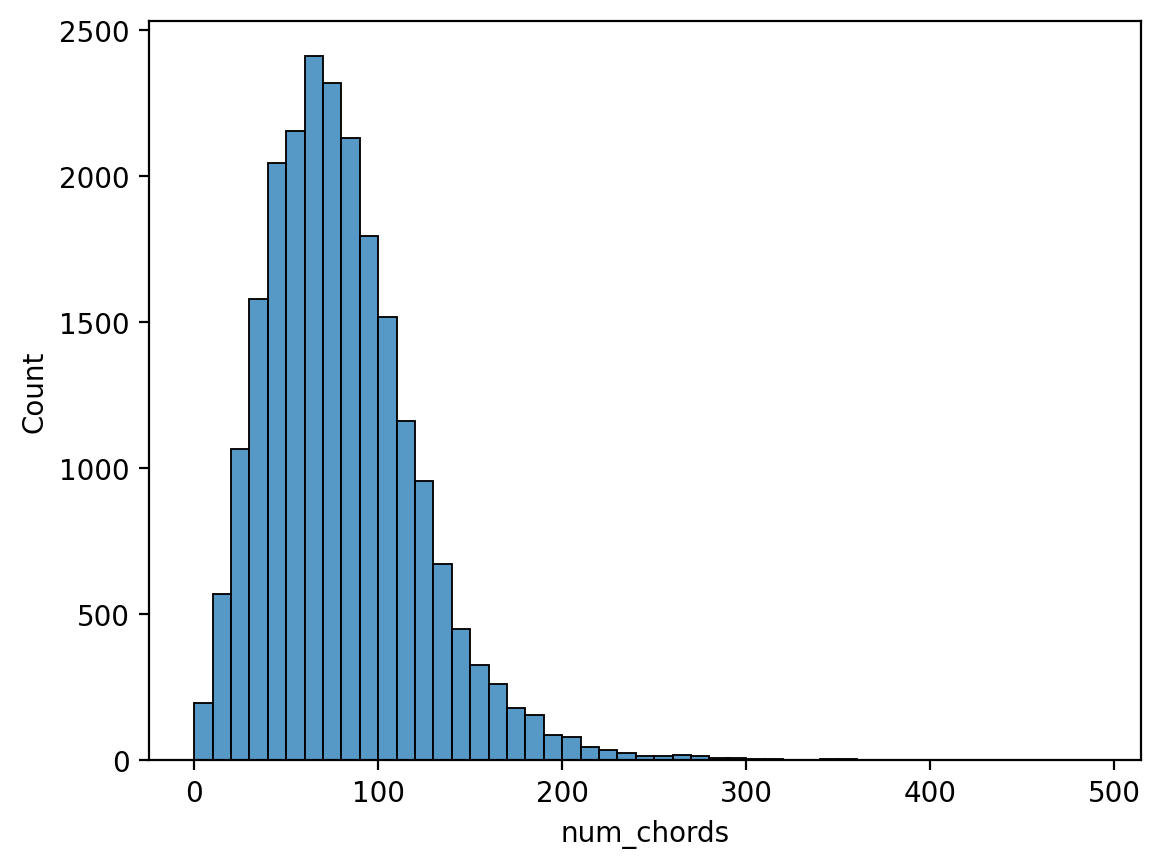

In [31]:
# Show the distribution of the number of chords in a song
sns.histplot(data_for_eda["num_chords"], bins=[i for i in range(0, 500, 10)])
np.array(data_for_eda["num_chords"]).mean()

7.20471208869814

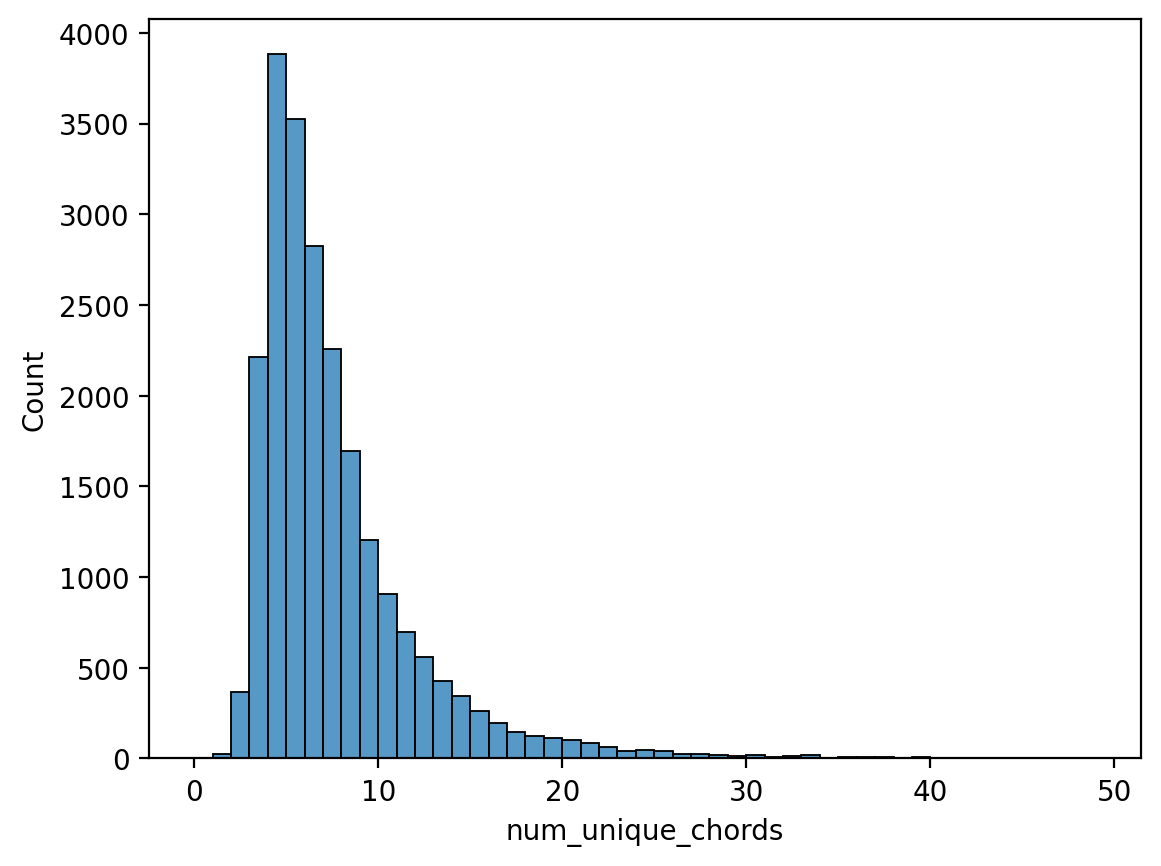

In [32]:
# Show the distribution of the number of unique chords in a song
sns.histplot(data_for_eda["num_unique_chords"], bins=[i for i in range(0, 50, 1)])
np.array(data_for_eda["num_unique_chords"]).mean()

5.226260729613734

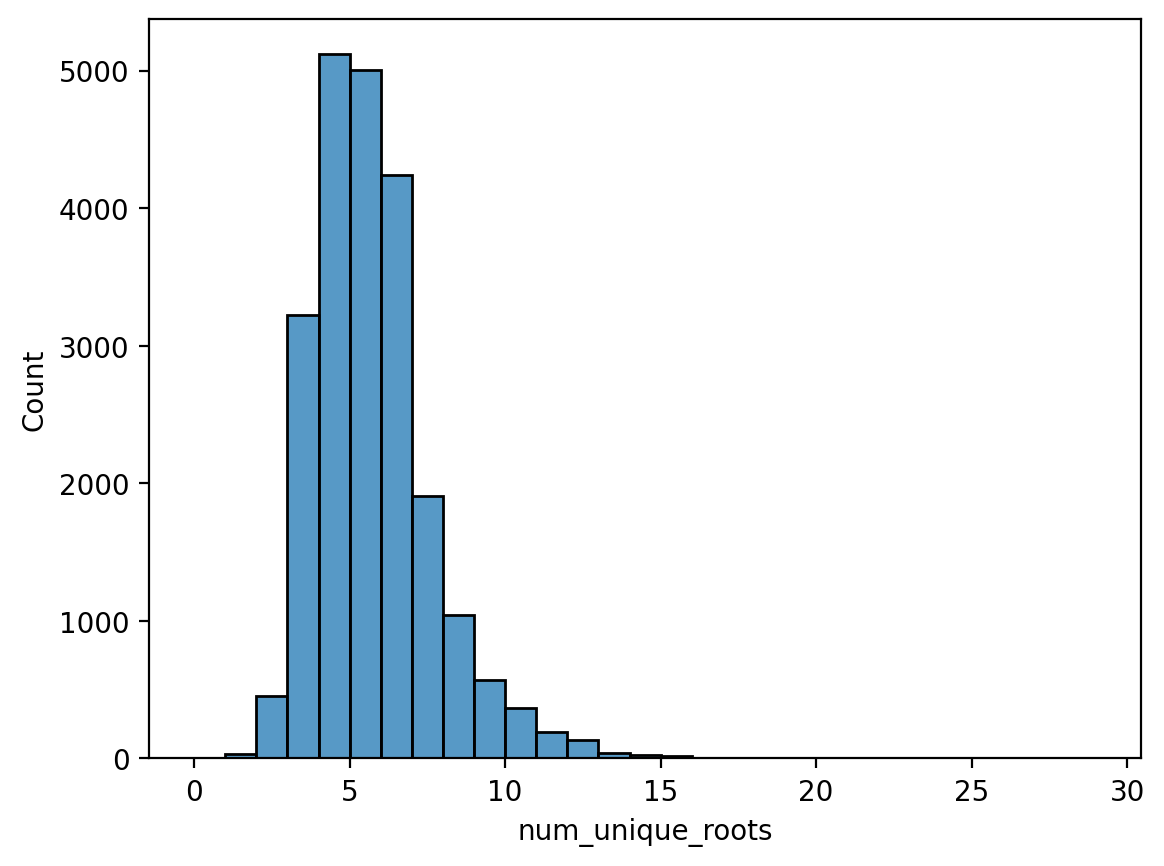

In [33]:
# Show the distribution of the number of unique roots in a song
sns.histplot(data_for_eda["num_unique_roots"], bins=[i for i in range(0, 30, 1)])
np.array(data_for_eda["num_unique_roots"]).mean()

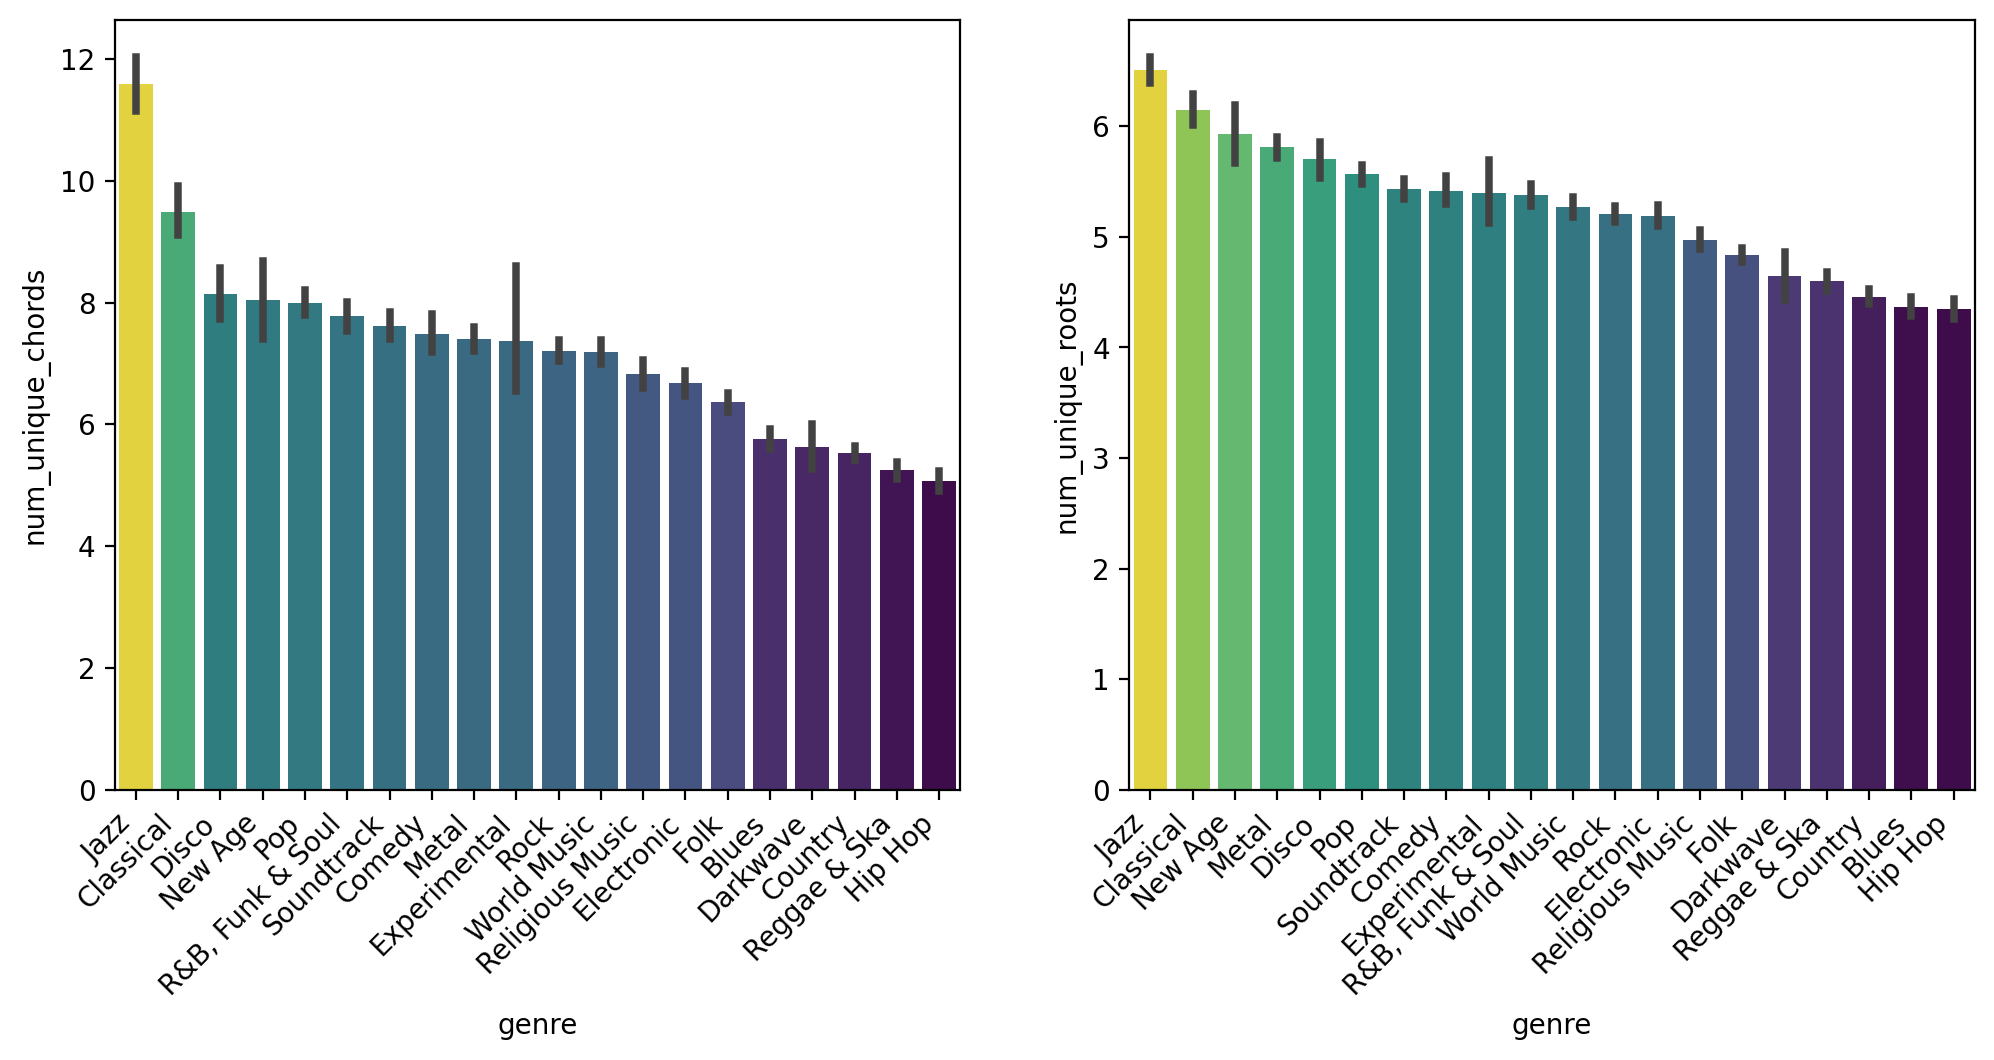

In [34]:
# Plot the number of unique chords and roots in each song by genre
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    plot_type = "num_unique_chords" if i == 0 else "num_unique_roots"
    order = (
        data_split[plot_type]
        .groupby(data_split["genre"])
        .mean()
        .sort_values(ascending=False)
        .index
    )
    means = data_split.groupby("genre")[plot_type].mean().sort_values(ascending=False)
    sns.barplot(
        x=data_split["genre"],
        y=data_split[plot_type],
        palette=color_by_height(means, "viridis"),
        order=order,
        ax=axes[i],
    )
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()

Jazz leads both in the number of unique chords and roots, while Hip Hop is at the last place. It is interesting to see a large range of uncertainty in the Experimental genre, suggesting that there are simple as well as more complex songs.

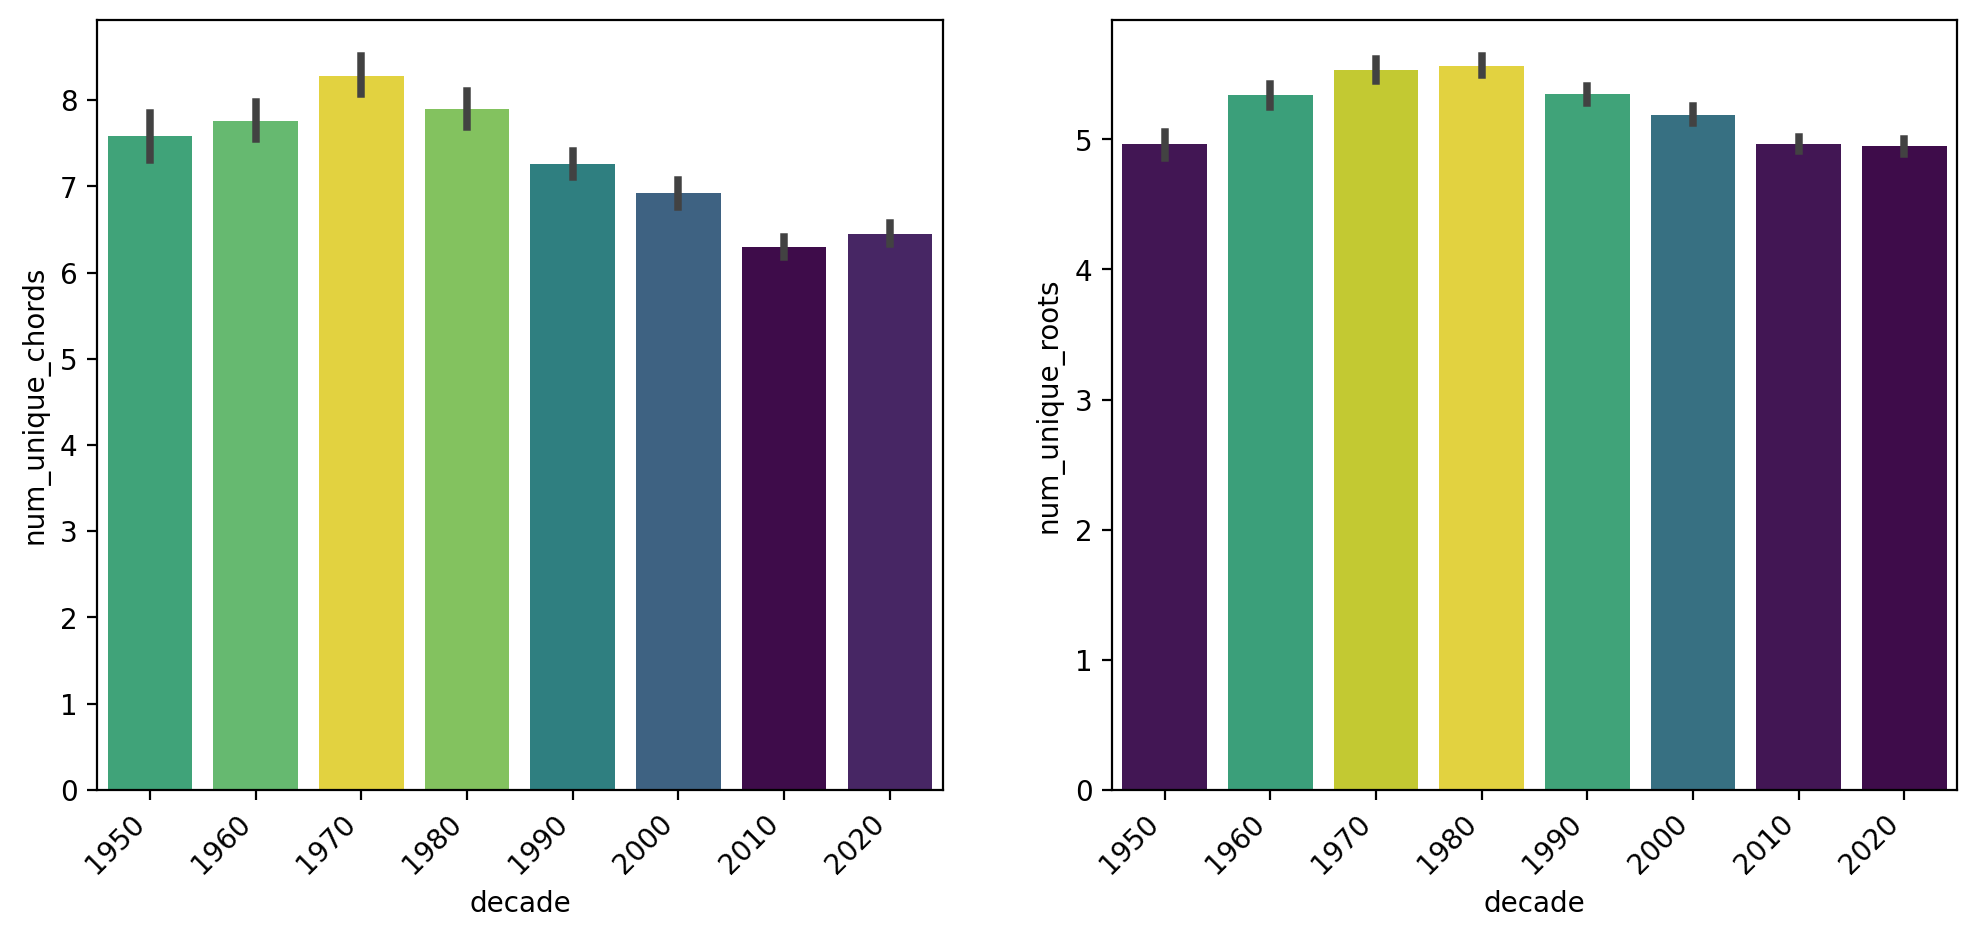

In [35]:
# Plot the average number of unique chords and roots per decade
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    plot_type = "num_unique_chords" if i == 0 else "num_unique_roots"
    decade_means = data_for_eda.groupby("decade")[plot_type].mean()
    sns.barplot(
        x=data_for_eda["decade"],
        y=data_for_eda[plot_type],
        palette=color_by_height(decade_means, "viridis"),
        ax=axes[i]
    )
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()

It seems that there is a peak around the 1970s and 1980s in the number of unique chords and roots used.

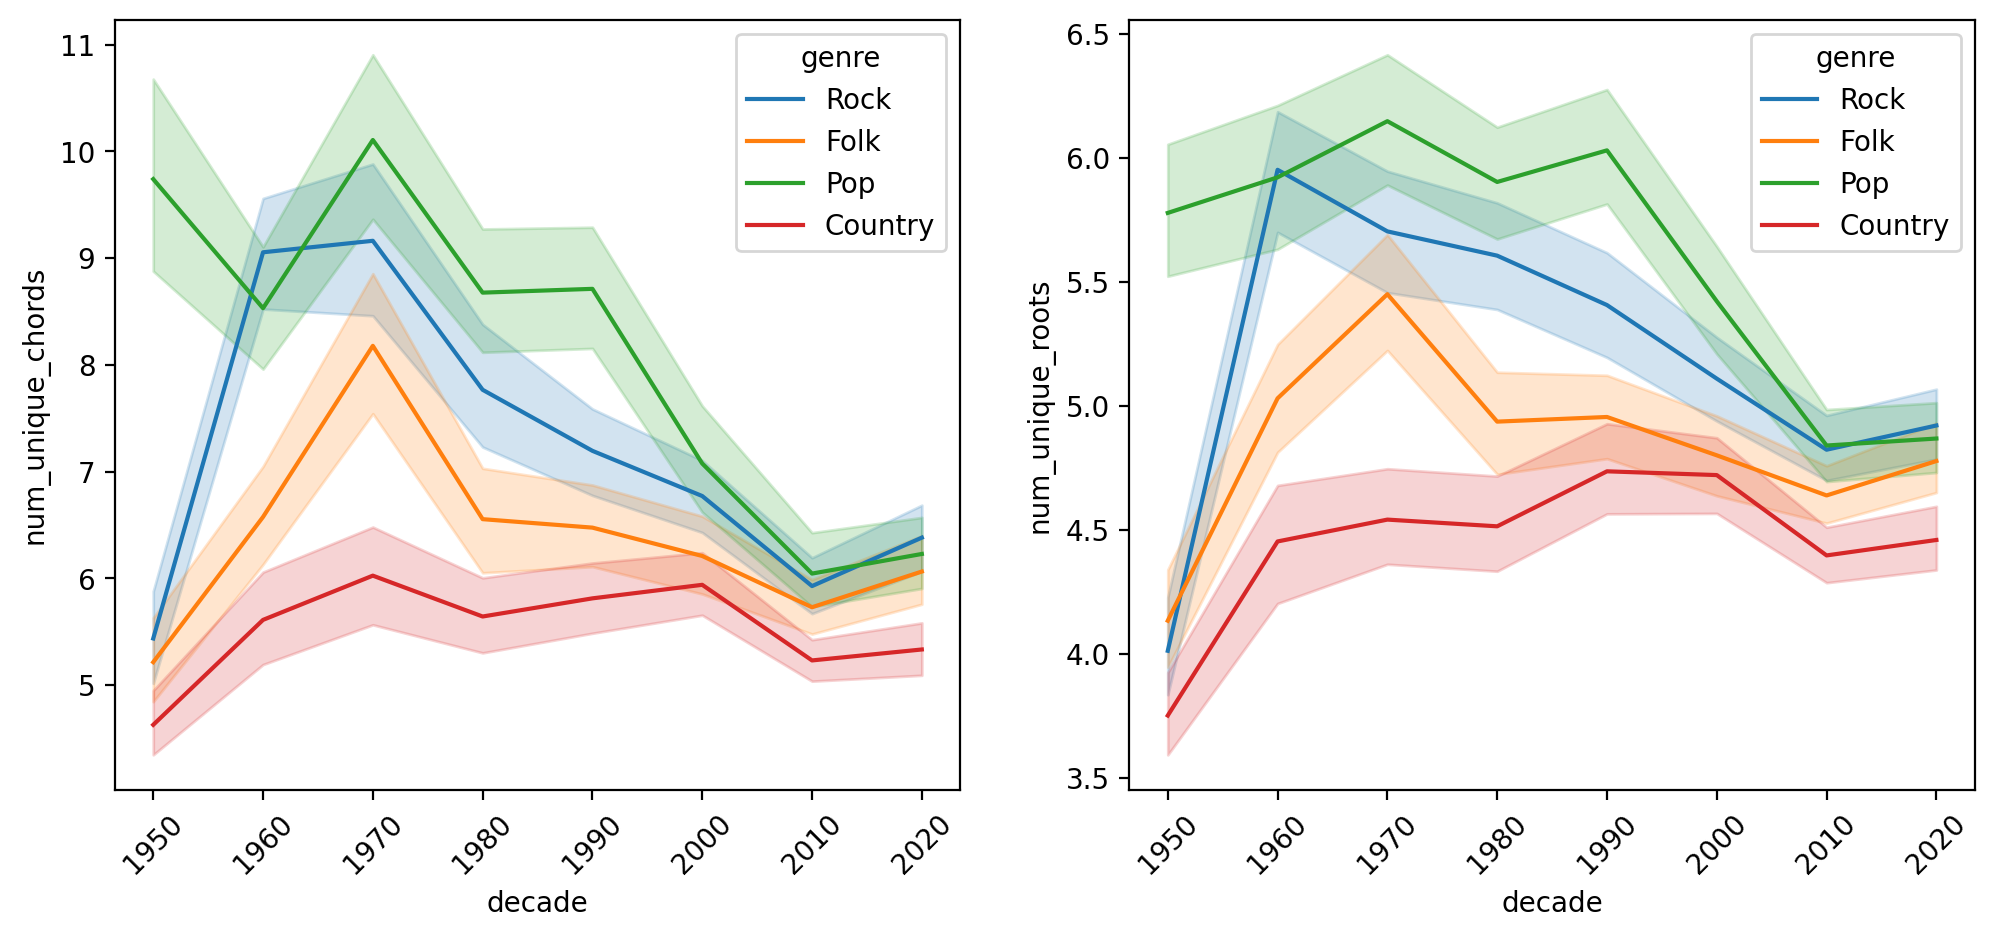

In [36]:
# Plot the average number of unique chords and roots over the decades of the most popular genres
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    plot_type = "num_unique_chords" if i == 0 else "num_unique_roots"
    selected_data = data_split[data_split["genre"].isin(["Rock", "Folk", "Country", "Pop"])]
    sns.lineplot(
        x=selected_data["decade"],
        y=selected_data[plot_type],
        hue=selected_data["genre"],
        ax=axes[i],
    )
    axes[i].tick_params(axis='x', rotation=45)

We can see a clear trend (among the most popular genres) that songs tend to get simpler over the years, both in terms of the unique chords used, and in the number of unique roots. It's especially clear with pop. Also we can see a slight deviation from this trend in the 1950s and 2020s.

#### Custom score

While the number of unique chords and roots can give a rough idea of the complexity of songs, we can also attempt to create a custom score for evaluating the complexity of chords. The suggested approach is based on obtaining the rough dissonance between the notes of the chord and using that to evaluate the complexity of the chord.

In [37]:
### Preprocessing ###
def interval_complexity(intvl_name):
    """Return a complexity score for the given interval."""
    scores = {
        "P1": 1, "m2": 5, "M2": 4, "m3": 3, "M3": 3,
        "P4": 2, "A4": 5, "d5": 5, "P5": 2, "m6": 3,
        "M6": 3, "m7": 4, "M7": 4, "P8": 1
    }
    return scores.get(intvl_name, 5) # Default to 5 for unknown intervals

def chord_complexity(ch):
    """Compute a complexity score based on intervals."""
    notes = ch.notes
    total_complexity = 0
    
    # Consider every pair of notes in the chord
    for i in range(len(notes)):
        for j in range(i+1, len(notes)):
            intvl = m21.interval.notesToInterval(notes[i], notes[j])
            
            # Reduce intervals larger than an octave
            if intvl.generic.undirected > 7:
                intvl = m21.interval.Interval(intvl.semitones % 12)
            
            total_complexity += interval_complexity(intvl.name)
    
    return total_complexity / len(notes)

In [38]:
# Get the complexity of each chord (takes quite a while to run)
chord_complexities = {}
for chord in all_chords:
    if chord in complete_chord_map and chord != "":
        m21_chord = m21.chord.Chord(complete_chord_map[chord])
        chord_complexities[chord] = chord_complexity(m21_chord)

In [39]:
# Get the complexity of each song
song_complexities = []
for index, row in data_for_eda.iterrows():
    chords = row["chords"].split(" ")
    complexity = 0
    for chord in chords:
        complexity += chord_complexities[chord]
    song_complexities.append(complexity / len(chords))

data_for_eda["song_complexity"] = song_complexities
data_split = data_for_eda.copy()
data_split = (
    data_for_eda.assign(genre=data["genre"].str.split("|"))
    .explode("genre")
    .reset_index(drop=True)
)

<AxesSubplot:xlabel='decade', ylabel='song_complexity'>

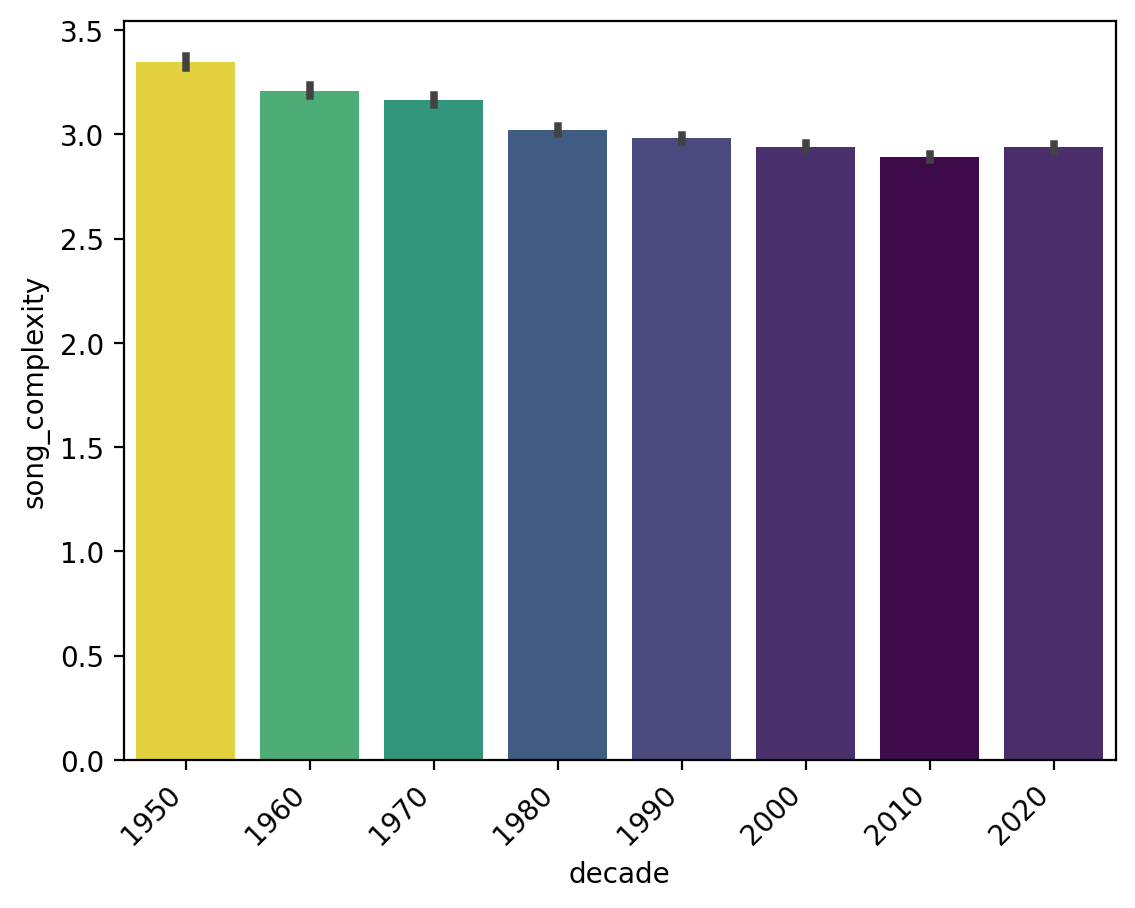

In [40]:
# Plot the complexity over the decades
plt.xticks(rotation=45, horizontalalignment="right")
decade_means = data_for_eda.groupby("decade")["song_complexity"].mean()
sns.barplot(
    x=data_for_eda["decade"],
    y=data_for_eda["song_complexity"],
    palette=color_by_height(decade_means, "viridis"),
)

We can see a trend in decreasing complexity with the exception of 2020s, suggesting that songs tend to be simpler over time.

<AxesSubplot:xlabel='genre', ylabel='song_complexity'>

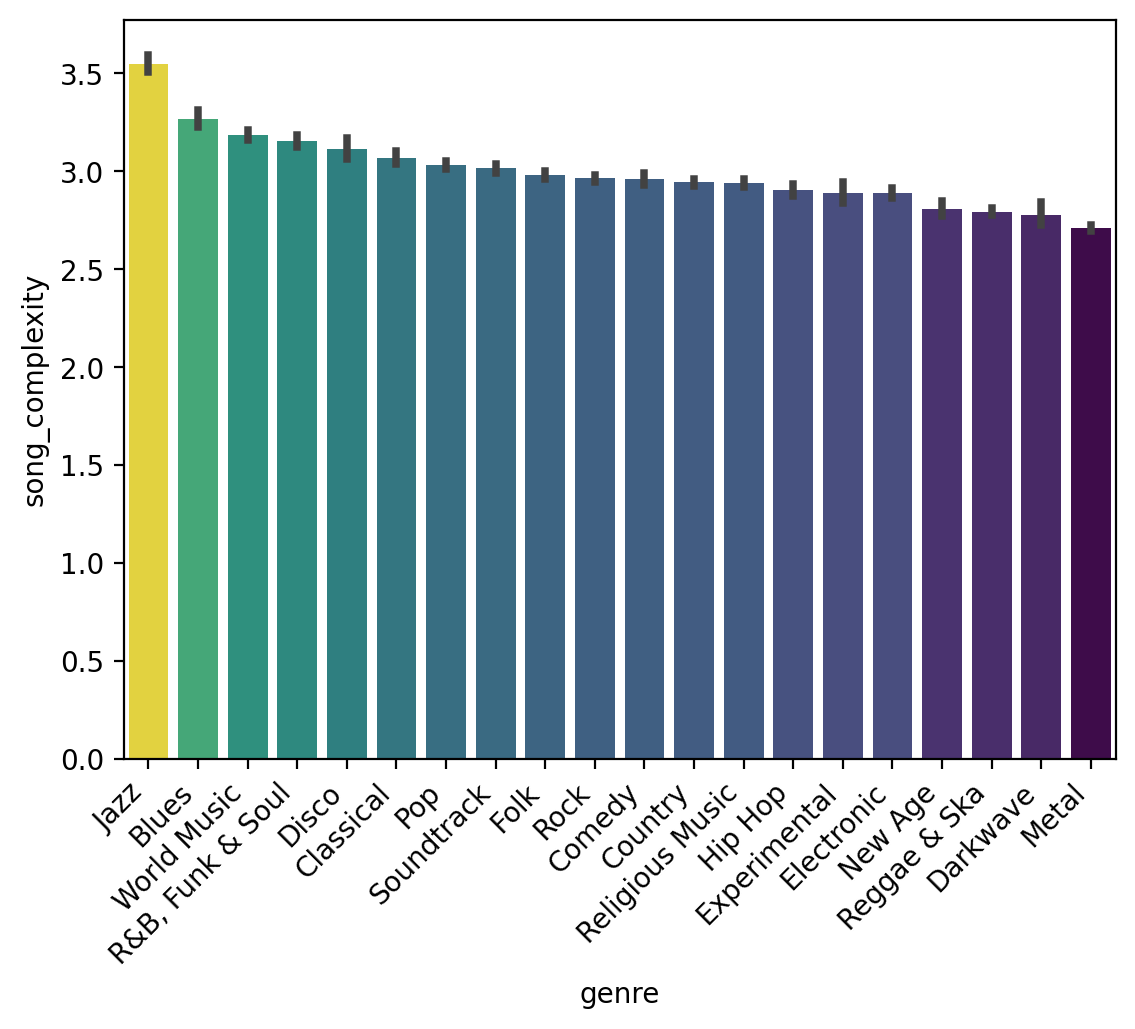

In [41]:
# Plot the average complexity of each genre
plt.xticks(rotation=45, horizontalalignment="right")
order = (
    data_split["song_complexity"]
    .groupby(data_split["genre"])
    .mean()
    .sort_values(ascending=False)
    .index
)
genre_means = data_split.groupby("genre")["song_complexity"].mean().sort_values(ascending=False)
sns.barplot(
    x=data_split["genre"],
    y=data_split["song_complexity"],
    order=order,
    palette=color_by_height(genre_means, "viridis"),
)

Unsurprisingly, Jazz is by a margin the most complex genre based on our metric. It is interesting to note that while the evaluation of uniqueness placed Blues in one of the last places, it is the second most complex. Instead of Hip Hop being last, we find Metal here. We hypothesize that this is due to Metal mostly using just minor and major chords, while it is more common to find more complex chords in Hip Hop.

<AxesSubplot:xlabel='decade', ylabel='song_complexity'>

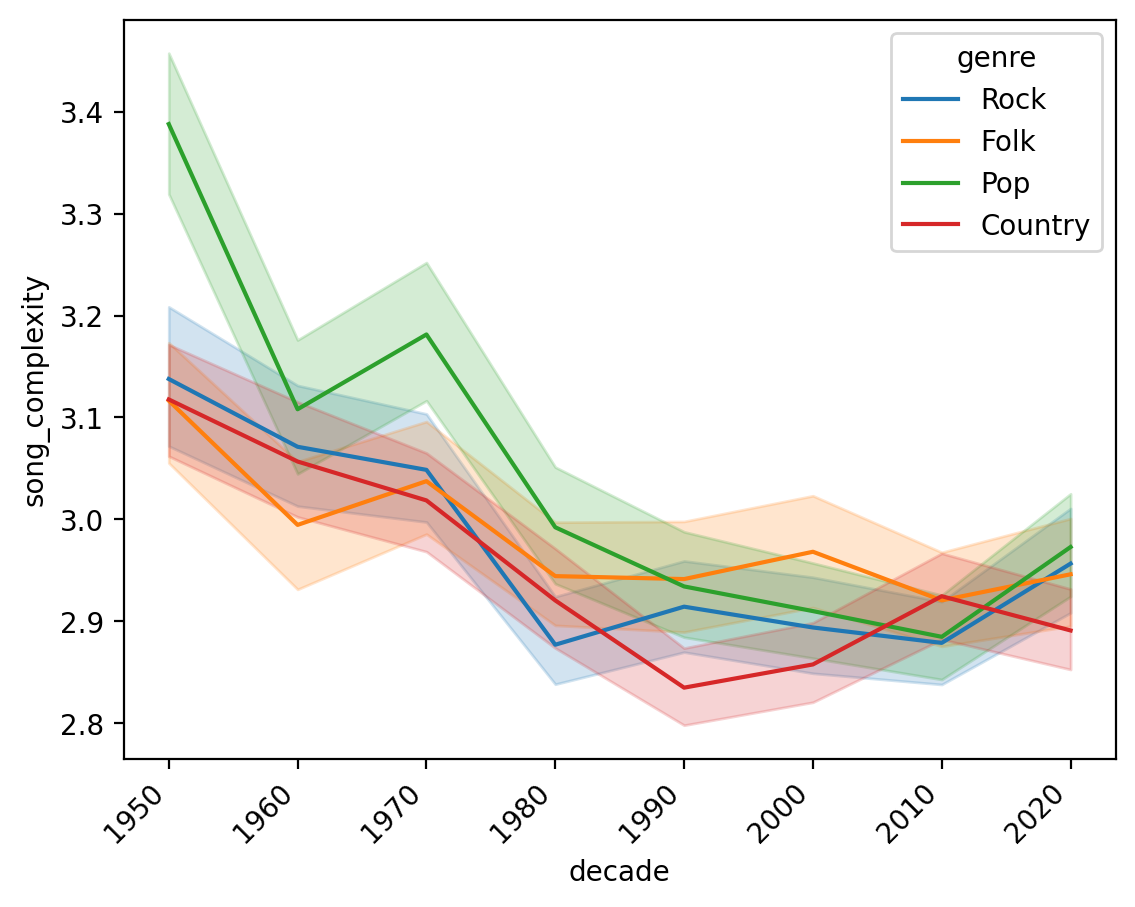

In [42]:
# Plot the average complexity of songs over the decades of the most popular genres
plt.xticks(rotation=45, horizontalalignment="right")
selected_data = data_split[data_split["genre"].isin(["Rock", "Folk", "Country", "Pop"])]
sns.lineplot(
    x=selected_data["decade"],
    y=selected_data["song_complexity"],
    hue=selected_data["genre"],
)

The trend is clear - chord progressions tend to get simpler over time, except possibly for the exception of the 2020s.

In [43]:
### Complexity along artists
artist_means = data_split.groupby("artist")["song_complexity"].mean().sort_values(ascending=False)

# Filter out artists with less than 10 songs
artist_means = artist_means[data_split.groupby("artist")["title"].count() >= 10]

# Show the artists with the most complex songs
top_artists = artist_means[:10].reset_index()
top_artists["genre"] = top_artists["artist"].map(data_split.groupby("artist")["genre"].unique().apply(list))
top_artists["songs"] = top_artists["artist"].map(data_split.groupby("artist")["title"].count())
top_artists

,artist,song_complexity,genre,songs
0,Donald Fagen,5.497584,[Jazz],24
1,Al Jarreau,4.718174,[Jazz],19
2,Antônio Carlos Jobim,4.701034,"[World Music, Jazz]",19
3,"Earth, Wind & Fire",4.693181,"[R&B, Funk & Soul, Jazz, Disco]",10
4,Michael Franks,4.323559,[Jazz],25
5,João Gilberto,4.291130,"[World Music, Jazz]",17
6,Muddy Waters,4.268810,[Blues],61
7,Laufey,4.234796,"[Jazz, Rock]",16
8,Billie Holiday,4.141910,[Jazz],11
9,Madeleine Peyroux,4.056524,[Jazz],14


In [44]:
# Show the artists with the least complex songs
bottom_artists = artist_means[-10:].reset_index()
bottom_artists["genre"] = bottom_artists["artist"].map(data_split.groupby("artist")["genre"].unique().apply(list))
bottom_artists["songs"] = bottom_artists["artist"].map(data_split.groupby("artist")["title"].count())
bottom_artists.sort_values(by="song_complexity")

,artist,song_complexity,genre,songs
9,Metallica,2.341733,"[Rock, Metal]",33
8,Scorpions,2.528457,"[Rock, Metal]",32
7,Motörhead,2.533841,[Metal],22
6,Jeff Williams,2.547362,"[Metal, Soundtrack]",11
5,Ska-P,2.562334,[Reggae & Ska],26
4,A Perfect Circle,2.562894,[Metal],10
3,Sabaton,2.591979,[Metal],25
2,Green Day,2.615233,[Rock],14
1,I Prevail,2.626469,"[Metal, Electronic]",11
0,HIM,2.641775,[Metal],17


<AxesSubplot:xlabel='song_complexity', ylabel='ratings'>

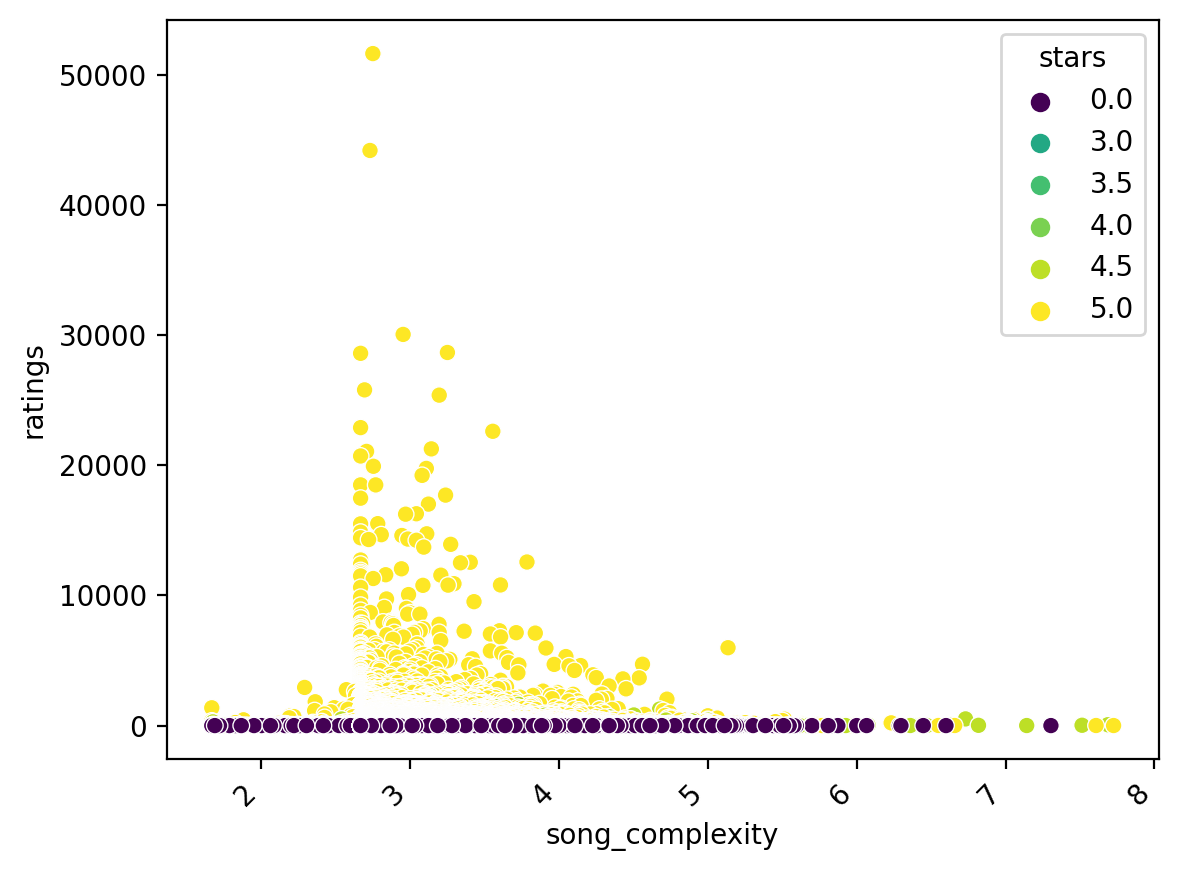

In [45]:
# Plot the popularity of the songs and their complexity
plt.xticks(rotation=45, horizontalalignment="right")

sns.scatterplot(
    x=data_for_eda["song_complexity"],
    y=data_for_eda["ratings"],
    hue=data_for_eda["stars"],
    palette="viridis",
)

It seems that the most popular songs have reached a certain level of complexity of the chords used, after which there is a tendency for more complex songs to be less popular.

### Chord progressions

#### Chord n-gram analysis

In [46]:
### Preprocessing ###
def get_root(chord):
    if len(chord) > 1 and (chord[1] == "#" or chord[1] == "b"):
        return chord[:2]
    return chord[0]

def get_root_ext(chord):
    if len(chord) > 1 and (chord[1] == "#" or chord[1] == "b"):
        return chord[:2], chord[2:]
    return chord[0], chord[1:]

# The music21 library is quite slow, so we will precompute a map of all possible chords
roman_map = {}
notes = ["C", "C#", "C-", "D", "D#", "D-", "E", "E-", "F", "F#", "F-", "G", "G#", "G-", "A", "A#", "A-", "B", "B-", "B#"]
for key in notes:
    for root in notes:
        figure = m21.roman.romanNumeralFromChord(m21.chord.Chord(root), key).figure
        # Upper the figure except for the bbb, bb, b, #, ##, ### in the beggining (if there is one)
        match = re.match(r'^(bbb|bb|b|#|##|###)?(.*)', figure)
        if match:
            accidentals, numeral = match.groups()
            if not accidentals:
                accidentals = ''
            figure = accidentals + numeral.upper()

        roman_map[f"{key} {root}"] = figure
            
def get_roman(key, root):
    """Get the roman numeral of the root of chord in the context of some key."""
    roman_pair = key.replace("b", "-") + " " + root.replace("b", "-")
    if roman_pair in roman_map:
        return roman_map[roman_pair]
    print(f"Could not find {roman_pair}")
    return "N/A"

def get_full_roman(key, chord):
    """Get the roman numeral of the chord in the context of some key."""
    root, ext = get_root_ext(chord)
    ext = update_if_slash(root, ext)
    roman = get_roman(key, root)
    return f"{roman} {ext}".strip()

# Get the relative chords for each song
relative_chords = []
for index, row in data.iterrows():
    chords = row["chords"].split(" ")
    # We assume that the first chord is the key of the song for now
    # Later, the n-grams are normalized, so it is not important whether it is the key or not
    key = get_root(chords[0])
    relative_chords.append([get_full_roman(key, chord) for chord in chords])

# Add the relative chords to the dataframe
data_for_eda = data.copy()
data_for_eda["relative_chords"] = relative_chords
data_split = data_for_eda.copy()
data_split = (
    data_for_eda.assign(genre=data["genre"].str.split("|"))
    .explode("genre")
    .reset_index(drop=True)
)

Songs quite often use repeating sequences of chords (e.g. four chords songs are quite common), where n-gram analysis would yield four different n-grams of chords. It is therefore helpful to define a unique way to categorize all such n-grams as a single n-gram. This can be for example accomplished by defining cyclic permutations and using the one that is the first in numerical order (e.g. from `V VI IV I` we would get `I V VI IV`).

In [47]:
### Defining cyclic permutations ###
basic_roman_numerals = ["I", "II", "III", "IV", "V", "VI", "VII"]
modifiers = ["bbb", "bb", "b", "", "#", "##", "###"]
roman_numerals = [mod + numeral for numeral in basic_roman_numerals for mod in modifiers]
roman_numeral_to_int = {roman: i for i, roman in enumerate(roman_numerals)}

basic_semitone_distances = {
    "I": 0, "II": 2, "III": 4, "IV": 5, "V": 7, "VI": 9, "VII": 11,
}
semitone_distances = {}
for mod in modifiers:
    for roman, semitones in basic_semitone_distances.items():
        semitone_distances[mod + roman] = semitones + len(mod) * (1 if len(mod) > 1 and mod[0] == "#" else -1)
        
# Construct the inverse as the simplest way to get a roman from a number
inverse_semitone_distances = {}
for roman, semitones in semitone_distances.items():
    if semitones not in inverse_semitone_distances:
        inverse_semitone_distances[semitones] = roman
    else:
        # We want to use the shortest modifier
        curr_longest_mod, present_longest_mod = "", ""
        for mod in modifiers:
            if mod in roman and len(mod) > len(curr_longest_mod):
                curr_longest_mod = mod
            if mod in inverse_semitone_distances[semitones] and len(mod) > len(present_longest_mod):
                present_longest_mod = mod
        if len(curr_longest_mod) < len(present_longest_mod):
            inverse_semitone_distances[semitones] = roman

def normalize_ngram(ngram):
    """Normalize an n-gram by transposing it to the lowest root."""
    lowest_root = min(ngram, key=lambda x: semitone_distances[x.split(" ")[0]]) .split(" ")[0]
    normalized_ngram = []
    for chord in ngram:
        splitted = chord.split(" ")
        root, extension = splitted[0], splitted[1] if len(splitted) > 1 else "" 
        normalized_root = semitone_distances[root] - semitone_distances[lowest_root]
        normalized_ngram.append((inverse_semitone_distances[normalized_root] + " " + extension).strip())
    return normalized_ngram

def get_cyclic_permutations(ngram):
    cycle = ngram + ngram
    permutations = []
    for i in range(len(ngram)):
        permutations.append(cycle[i : i + len(ngram)])
    return permutations


def custom_sort_key(chord):
    # Splitting the chord into roman numeral and chord extension
    parts = chord.split(" ")
    roman_part = parts[0]
    extension_part = parts[1] if len(parts) > 1 else ""

    # Using the roman numeral order and then the lexicographical order of the chord extension
    return (roman_numeral_to_int[roman_part], extension_part)


def get_root_cyclic_permutation(ngram):
    permutations = get_cyclic_permutations(ngram)
    permutations.sort(key=lambda x: [custom_sort_key(chord) for chord in x])
    return permutations[0]

In [48]:
# Analyze the ngram frequencies (takes a while to run)
bigram_frequency = {}
fourgram_frequency = {}
for index, row in data_for_eda.iterrows():
    relative_chords = row["relative_chords"]

    for i in range(len(relative_chords) - 1):
        bigram = normalize_ngram(relative_chords[i : i + 2])
        root = get_root_cyclic_permutation(bigram)
        bigram_frequency = update_frequency(bigram_frequency, "|".join(root))
        if i < len(relative_chords) - 3:
            fourgram = normalize_ngram(relative_chords[i : i + 4])
            root = get_root_cyclic_permutation(fourgram)
            fourgram_frequency = update_frequency(fourgram_frequency, "|".join(root))

<AxesSubplot:xlabel='bigram', ylabel='frequency'>

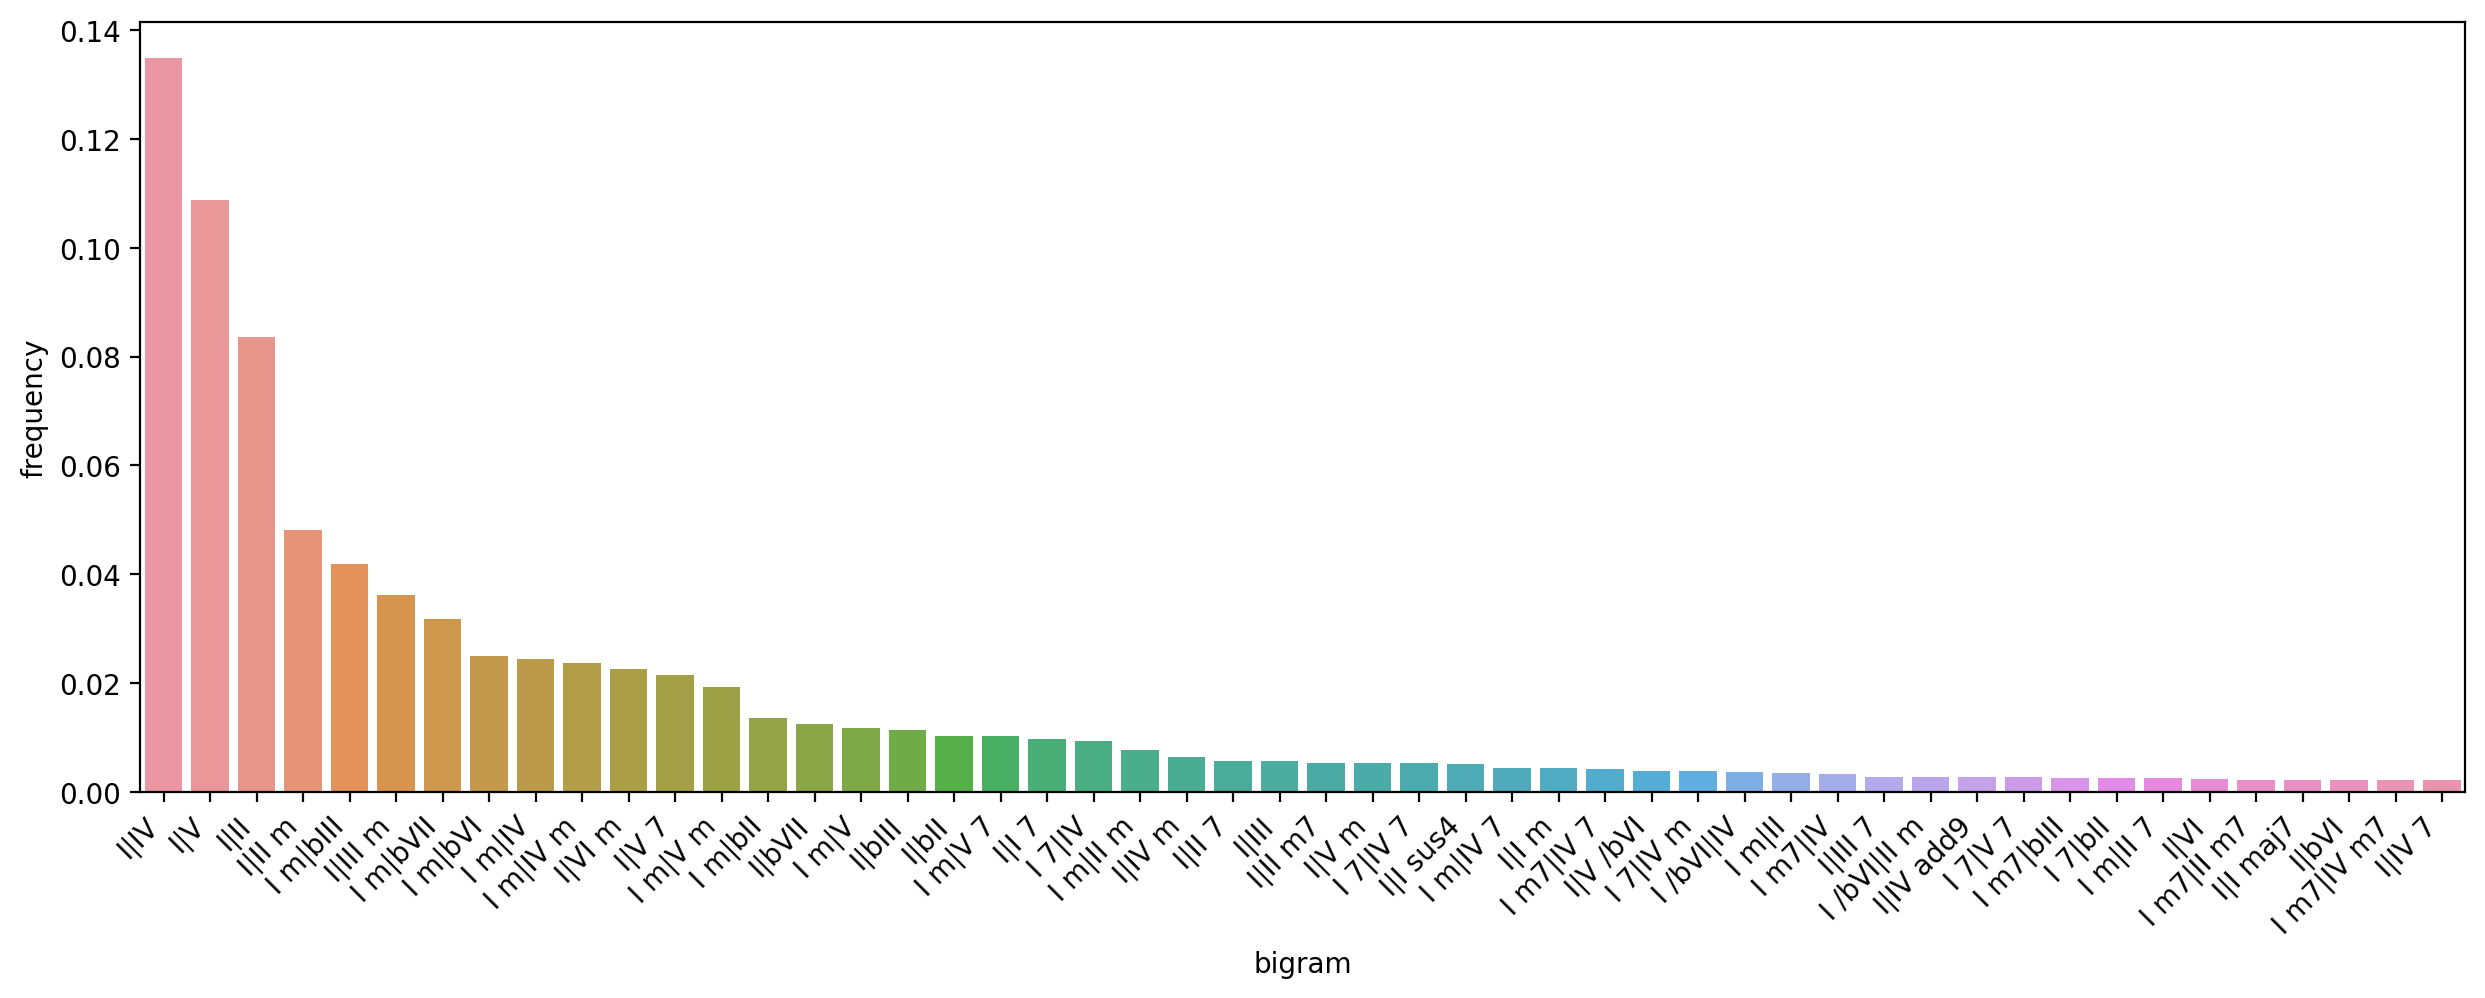

In [49]:
# Plot the most common bigrams
sorted_bigram_frequency = sorted(
    bigram_frequency.items(), key=lambda x: x[1], reverse=True
)
total_frequency = sum([value for _, value in sorted_bigram_frequency])
percentual_bigram_frequency = {
    key: value / total_frequency for key, value in sorted_bigram_frequency
}
percentual_bigram_frequency_df = pd.DataFrame(
    list(percentual_bigram_frequency.items()), columns=["bigram", "frequency"]
)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45, horizontalalignment="right")
sns.barplot(
    x=percentual_bigram_frequency_df["bigram"][:50],
    y=percentual_bigram_frequency_df["frequency"][:50],
)

<AxesSubplot:xlabel='fourgram', ylabel='frequency'>

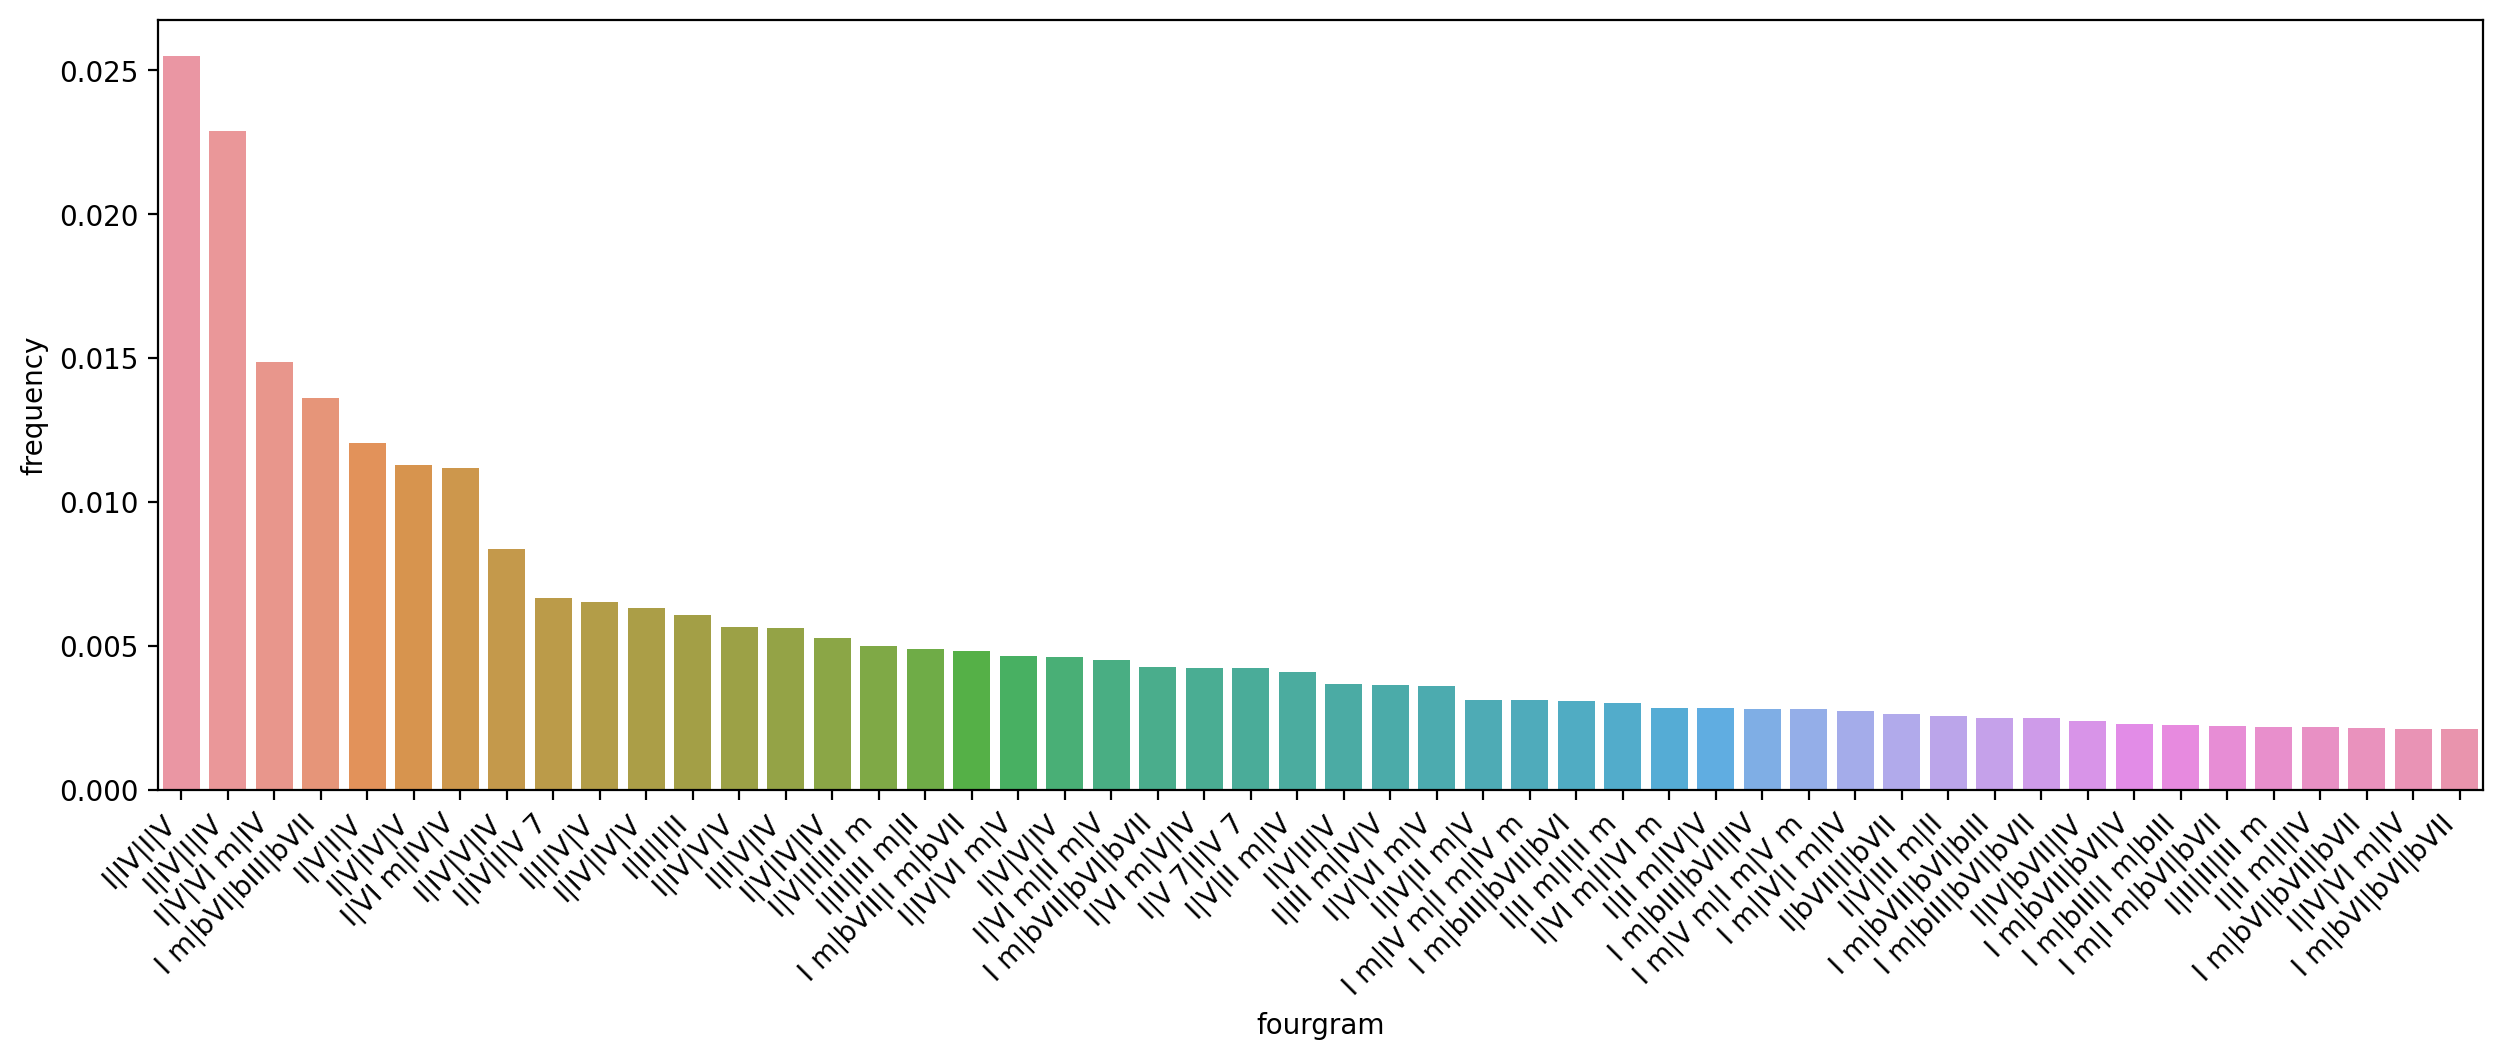

In [50]:
# Plot the most common fourgrams
sorted_fourgram_frequency = sorted(
    fourgram_frequency.items(), key=lambda x: x[1], reverse=True
)
total_frequency = sum([value for _, value in sorted_fourgram_frequency])
percentual_fourgram_frequency = {
    key: value / total_frequency for key, value in sorted_fourgram_frequency
}
percentual_fourgram_frequency_df = pd.DataFrame(
    list(percentual_fourgram_frequency.items()), columns=["fourgram", "frequency"]
)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45, horizontalalignment="right")
sns.barplot(
    x=percentual_fourgram_frequency_df["fourgram"][:50],
    y=percentual_fourgram_frequency_df["frequency"][:50],
)

In [51]:
# Analyze the ngram frequencies by genre (takes a while to run)
genre_bigram_frequency = {}
genre_fourgram_frequency = {}
for index, row in data_split.iterrows():
    relative_chords = row["relative_chords"]
    genre = row["genre"]

    for i in range(len(relative_chords) - 1):
        bigram = normalize_ngram(relative_chords[i : i + 2])
        root = get_root_cyclic_permutation(bigram)
        if genre not in genre_bigram_frequency:
            genre_bigram_frequency[genre] = {}
        genre_bigram_frequency[genre] = update_frequency(genre_bigram_frequency[genre], "|".join(root))
        if i < len(relative_chords) - 3:
            fourgram = normalize_ngram(relative_chords[i : i + 4])
            root = get_root_cyclic_permutation(fourgram)
            if genre not in genre_fourgram_frequency:
                genre_fourgram_frequency[genre] = {}
            genre_fourgram_frequency[genre] = update_frequency(genre_fourgram_frequency[genre], "|".join(root))

In [52]:
# Create a dataframe out of the genre bigram frequencies
genre_bigram_frequency_data = []
for genre, bigram_frequency in genre_bigram_frequency.items():
    for bigram, frequency in bigram_frequency.items():
        genre_bigram_frequency_df = genre_bigram_frequency_data.append(
            {"genre": genre, "bigram": bigram, "frequency": frequency}
        )
genre_bigram_frequency_df = pd.DataFrame(genre_bigram_frequency_data)

# Create a dataframe out of the genre fourgram frequencies
genre_fourgram_frequency_data = []
for genre, fourgram_frequency in genre_fourgram_frequency.items():
    for fourgram, frequency in fourgram_frequency.items():
        genre_fourgram_frequency_df = genre_fourgram_frequency_data.append(
            {"genre": genre, "fourgram": fourgram, "frequency": frequency}
        )
genre_fourgram_frequency_df = pd.DataFrame(genre_fourgram_frequency_data)

Let's plot the most common n-grams for the four most common genres, as well as the most and the least complex genres.

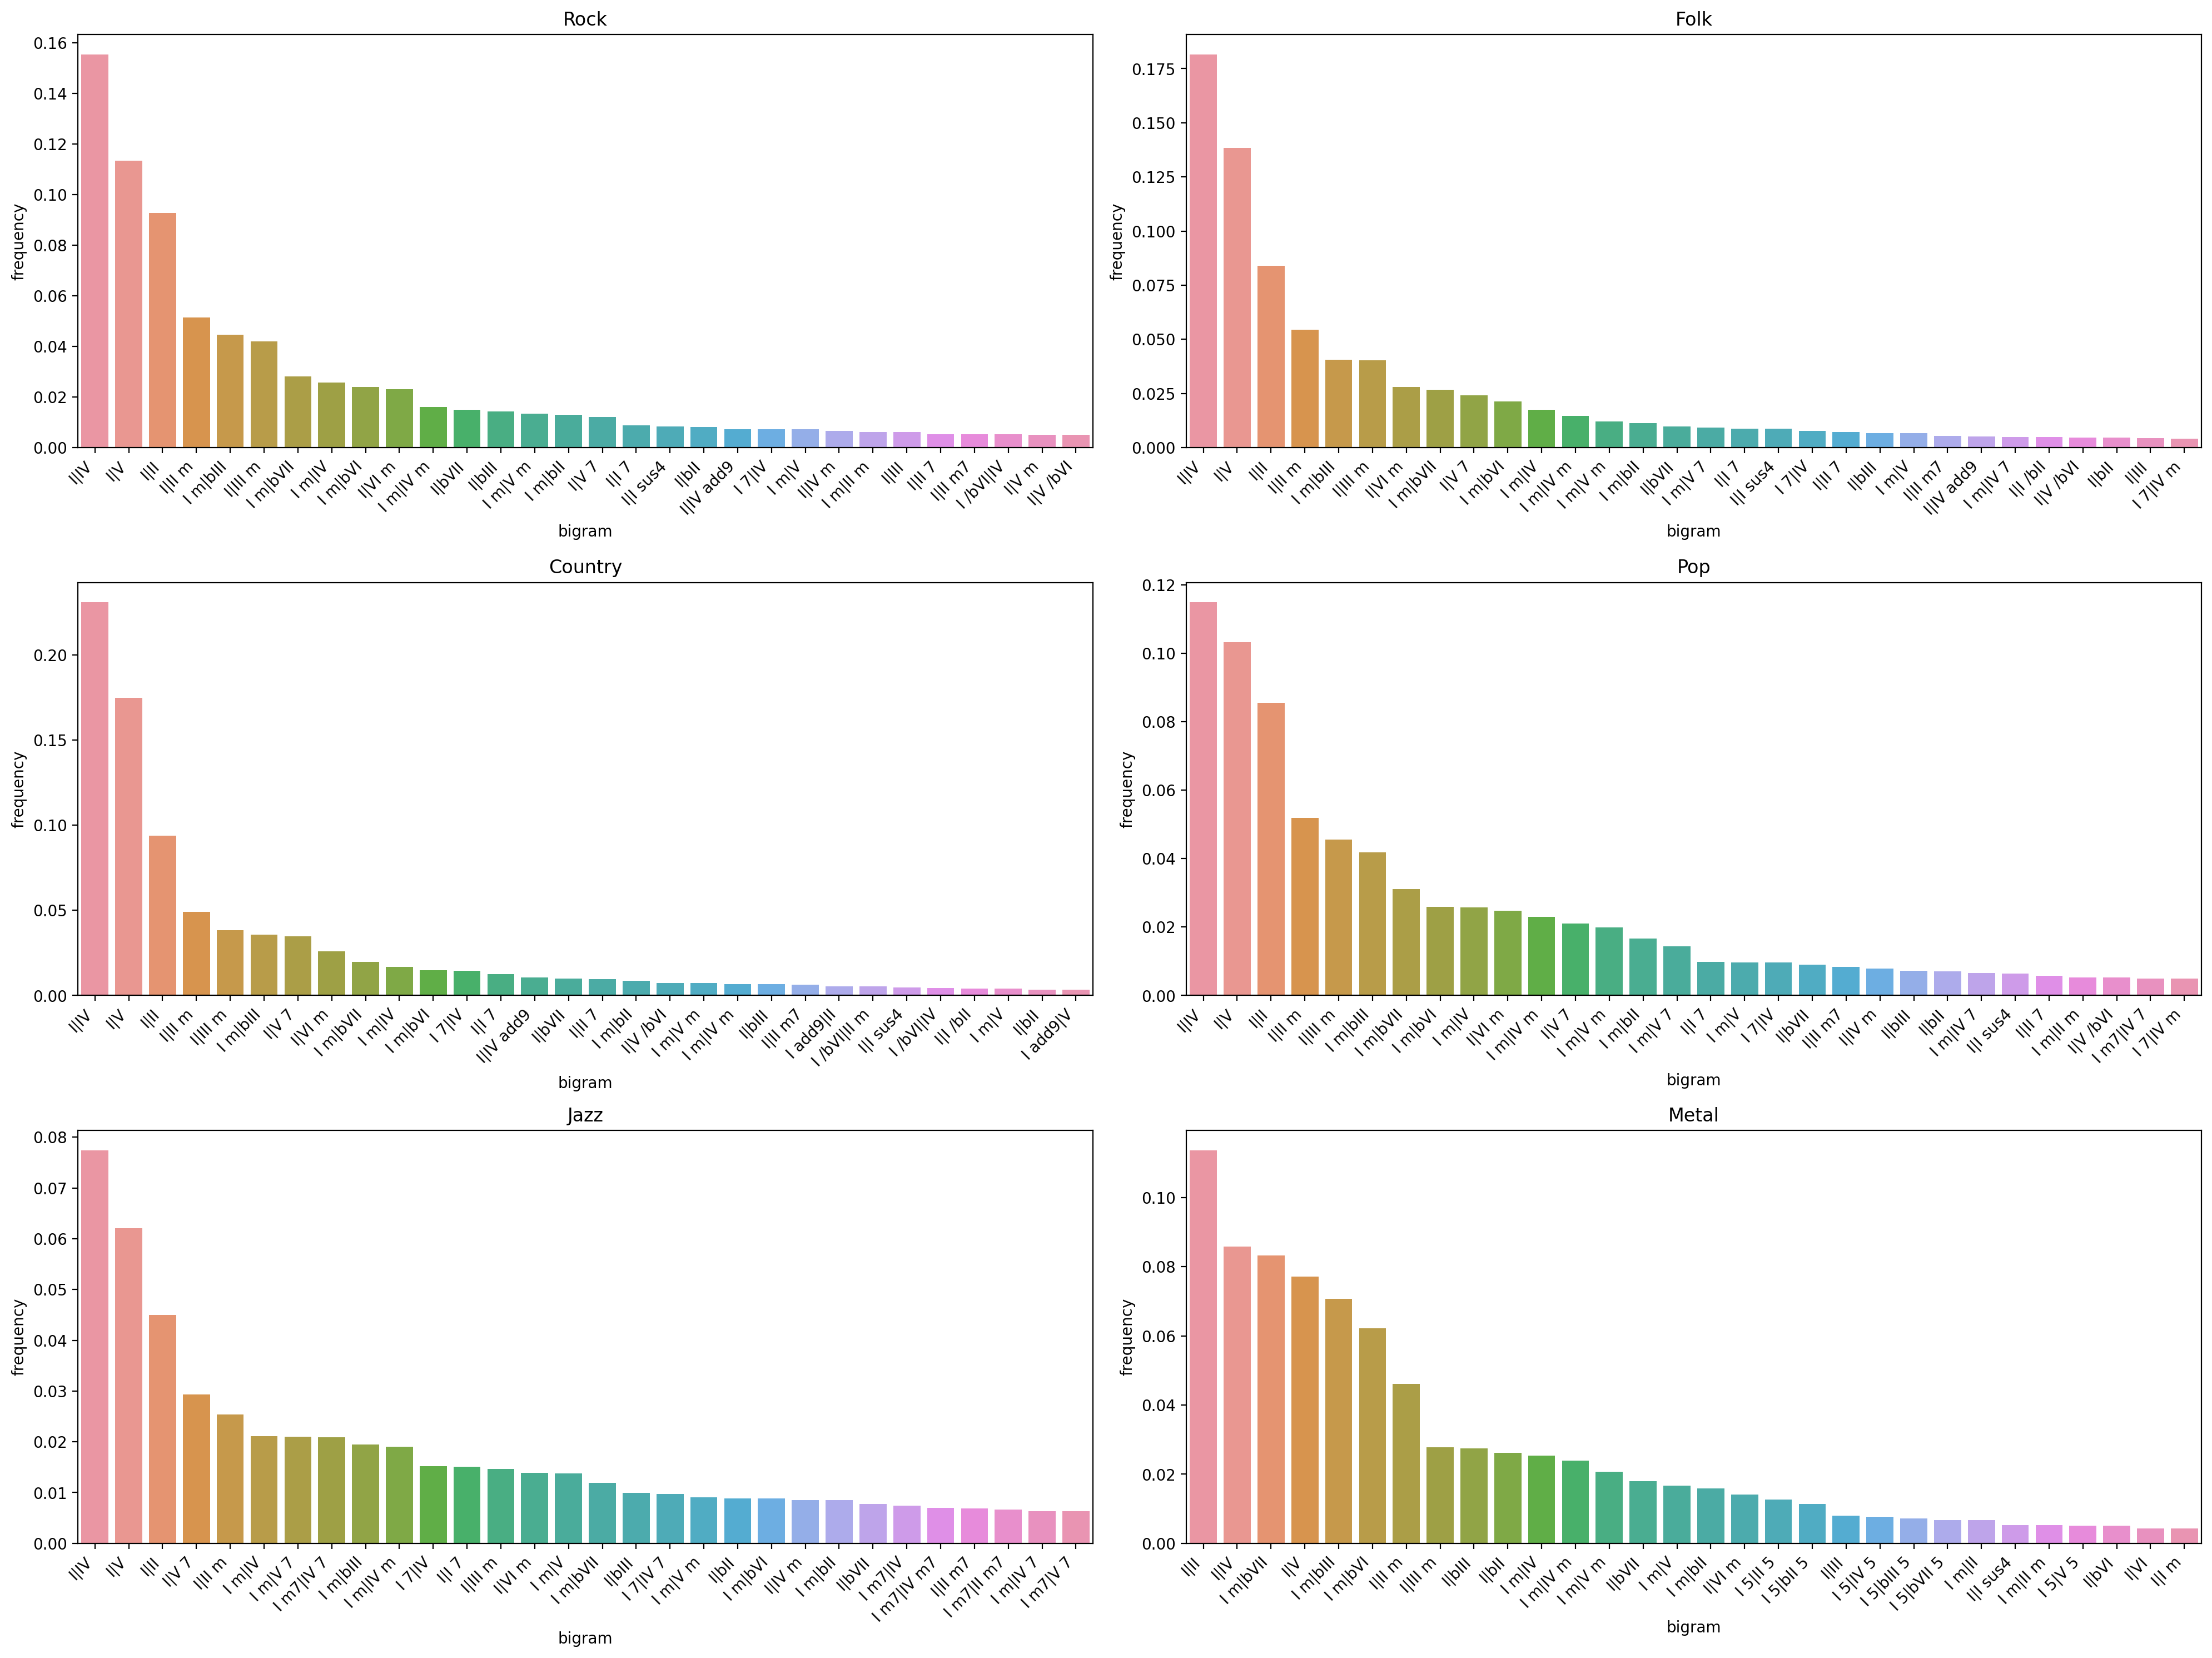

In [53]:
### Plot the most common bigrams ###
selected_genres = ["Rock", "Folk", "Country", "Pop", "Jazz", "Metal"]
selected_data = genre_bigram_frequency_df[genre_bigram_frequency_df["genre"].isin(selected_genres)]
selected_data = selected_data.sort_values(by="frequency", ascending=False)

# Normalize the frequencies by genre
selected_data["frequency"] = selected_data["frequency"] / selected_data.groupby("genre")["frequency"].transform("sum")

# Create plots for each genre
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.ravel()
for i in range(len(selected_genres)):
    genre = selected_genres[i]
    sns.barplot(
        x=selected_data["bigram"][selected_data["genre"] == genre].iloc[:30],
        y=selected_data["frequency"][selected_data["genre"] == genre].iloc[:30],
        ax=axes[i],
    )
    axes[i].set_title(genre)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
plt.show()

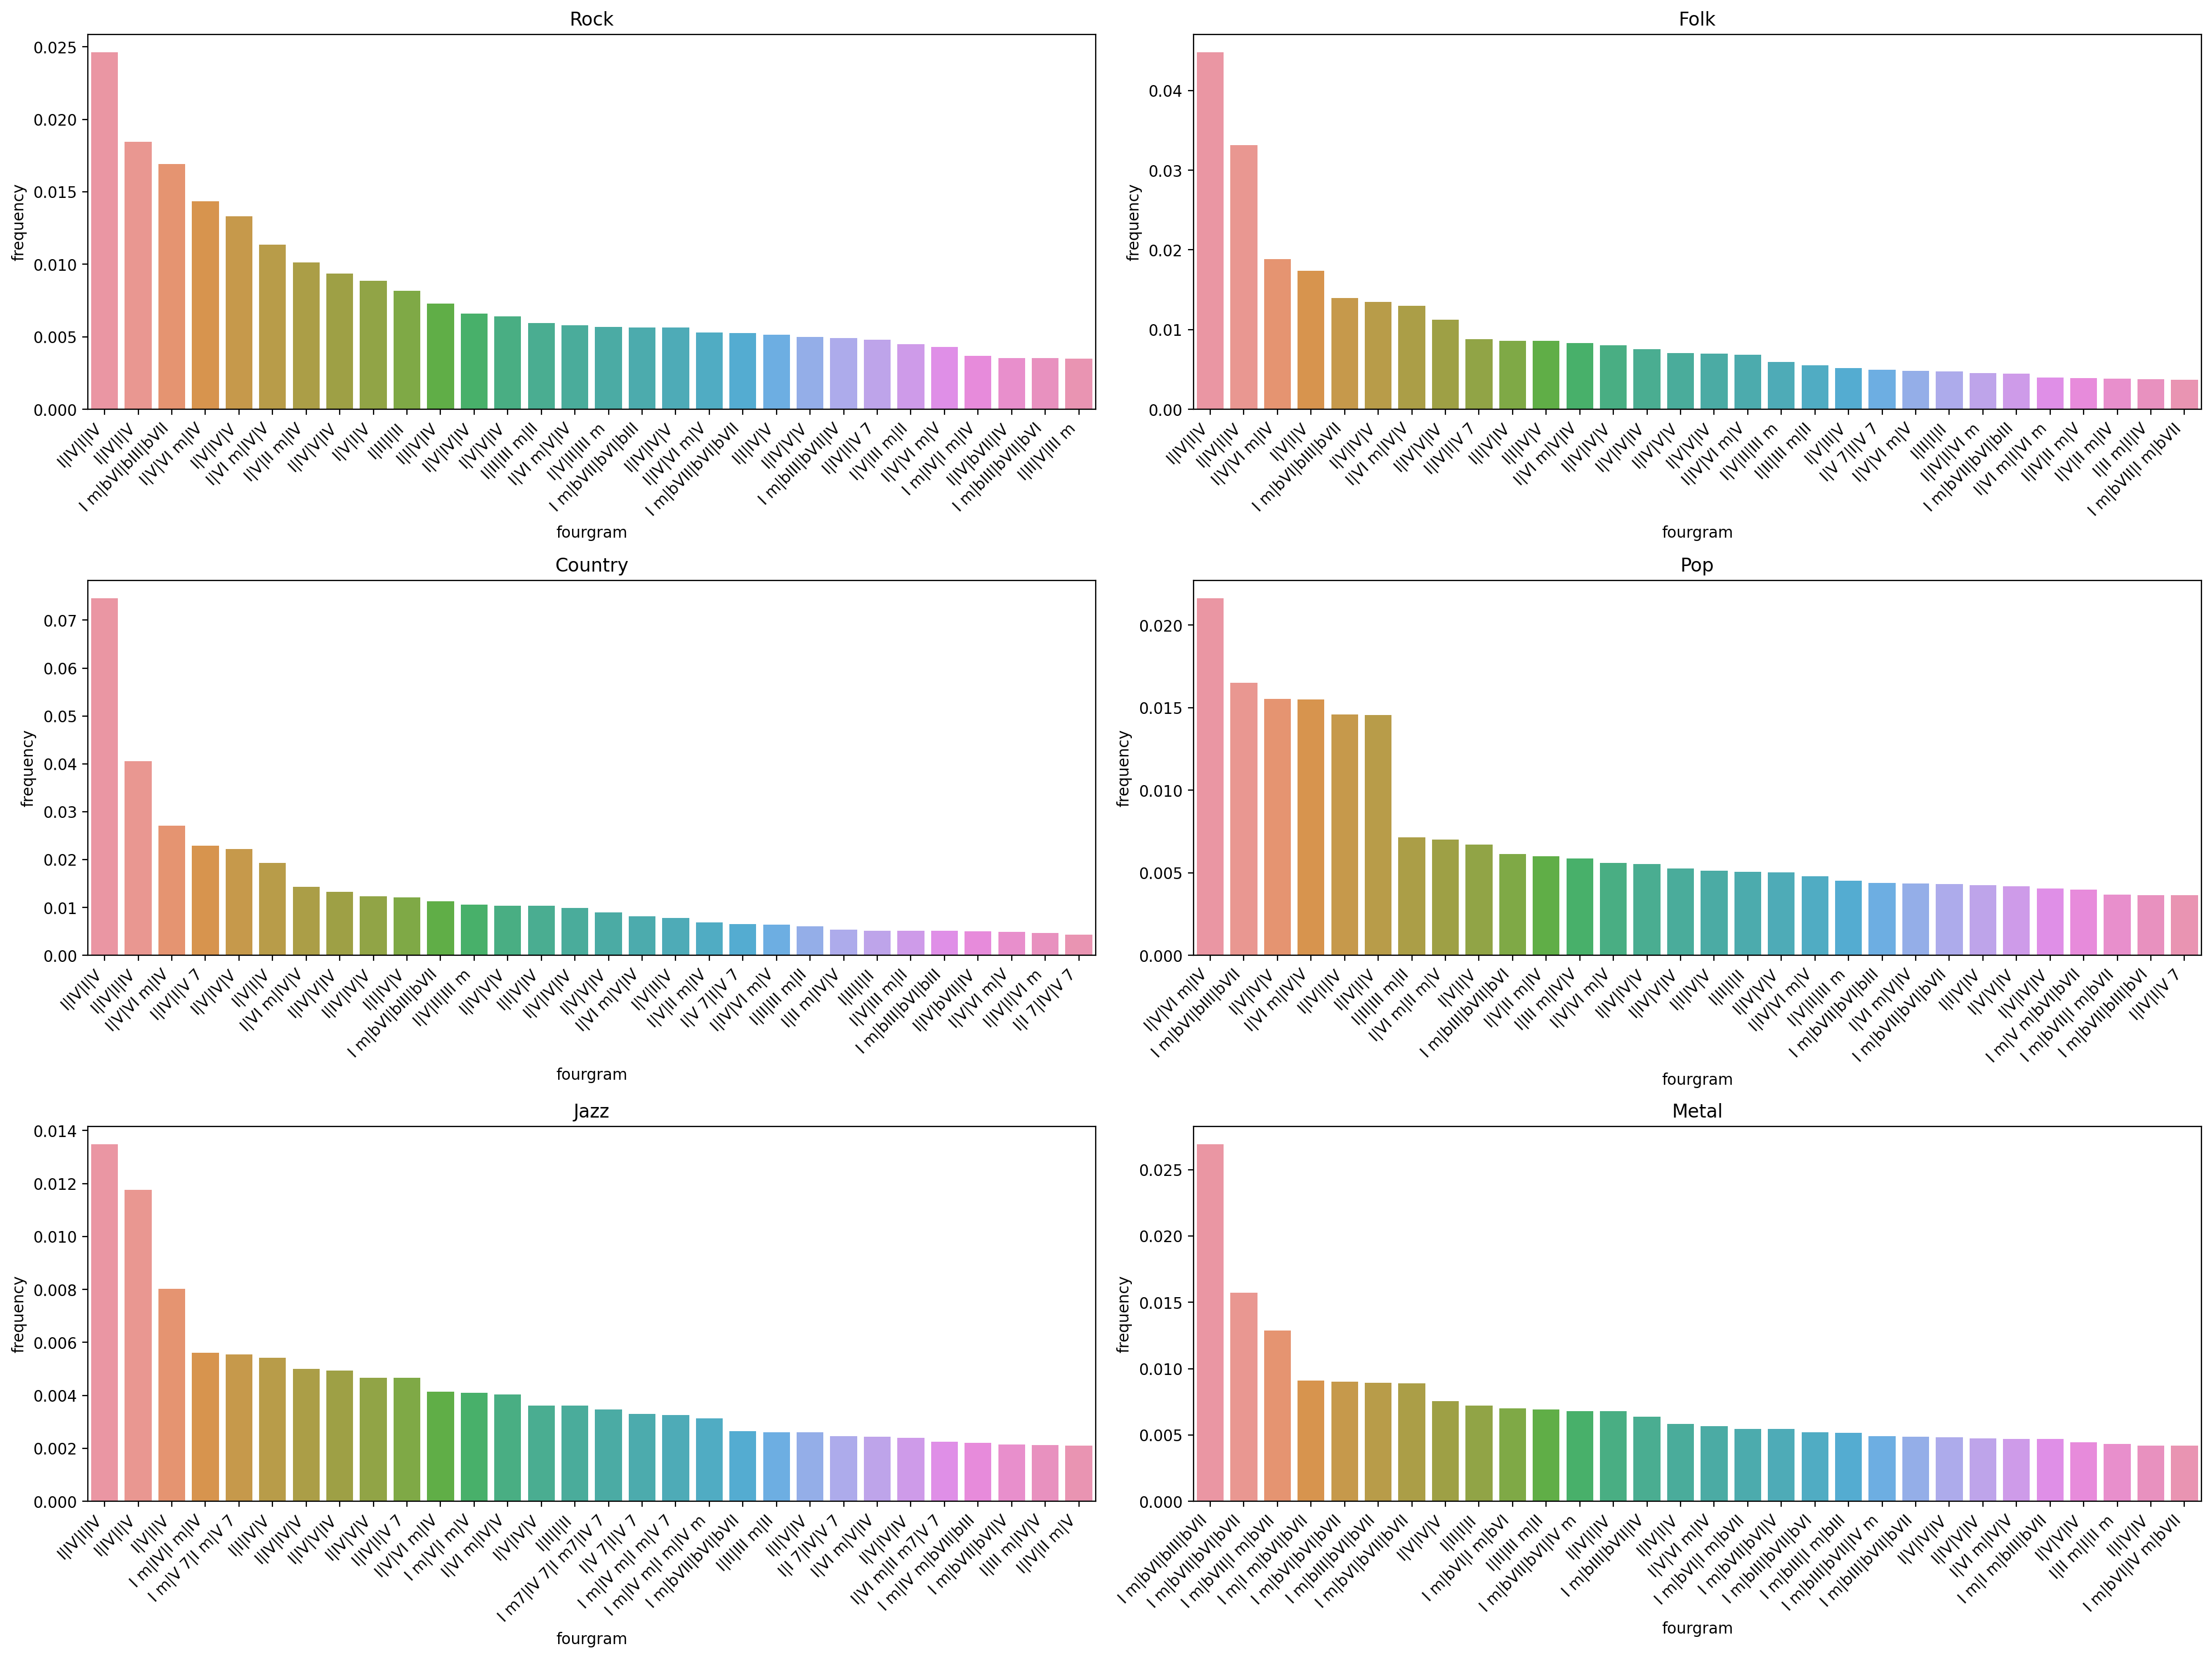

In [54]:
### Plot the most common fourgrams ###
selected_genres = ["Rock", "Folk", "Country", "Pop", "Jazz", "Metal"]
selected_data = genre_fourgram_frequency_df[genre_fourgram_frequency_df["genre"].isin(selected_genres)]
selected_data = selected_data.sort_values(by="frequency", ascending=False)

# Normalize the frequencies by genre
selected_data["frequency"] = selected_data["frequency"] / selected_data.groupby("genre")["frequency"].transform("sum")

# Create 5 different plots for each genre
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.ravel()
for i in range(len(selected_genres)):
    genre = selected_genres[i]
    sns.barplot(
        x=selected_data["fourgram"][selected_data["genre"] == genre].iloc[:30],
        y=selected_data["frequency"][selected_data["genre"] == genre].iloc[:30],
        ax=axes[i],
    )
    axes[i].set_title(genre)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, horizontalalignment="right")
plt.tight_layout()
plt.show()